In [31]:
# export PYTHONPATH="${PYTHONPATH}:/uio/kant/geo-geofag-u1/franzihe/Documents/Python/globalsnow/CloudSat_ERA5_CMIP6_analysis/utils/"

# Example with ERA5 high-resolution (~0.25deg) monthly means


# Table of Contents
<ul>
<li><a href="#introduction">1. Introduction</a></li>
<li><a href="#data_wrangling">2. Data Wrangling</a></li>
<li><a href="#exploratory">3. Exploratory Data Analysis</a></li>
<li><a href="#conclusion">4. Conclusion</a></li>
<li><a href="#references">5. References</a></li>
</ul>

# 1. Introduction <a id='introduction'></a>
Cloud feedbacks are a major contributor to the spread of climate sensitivity in global climate models (GCMs) ([Zelinka et al. (2020)](https://doi-org.ezproxy.uio.no/10.1029/2019GL085782)]). Among the most poorly understood cloud feedbacks is the one associated with the cloud phase, which is expected to be modified with climate change ([Bjordal et al. (2020)](https://doi-org.ezproxy.uio.no/10.1038/s41561-020-00649-1)). Cloud phase bias, in addition, has significant implications for the simulation of radiative properties and glacier and ice sheet mass balances in climate models. 

In this context, this work aims to expand our knowledge on how the representation of the cloud phase affects snow formation in GCMs. Better understanding this aspect is necessary to develop climate models further and improve future climate predictions. 

* Load ERA5 data previously downloaded locally via [Jupyter Notebook - download ERA5](https://github.com/franzihe/download_ERA5)
* find clouds: liquid-only, ice-only, mixed-phase
* Regridd the ERA5 variables to the same horizontal resolution as high-resolution CMIP6 models with [`xesmf`](https://xesmf.readthedocs.io/en/latest/)
* Calculate and plot the seasonal mean of the variable

**Questions**
* How is the cloud phase and snowfall varying between 1985 and 2014?


> **_NOTE:_** We answer questions related to the comparison of CMIP models to ERA5 in another [Jupyter Notebook](../CMIP6_ERA5_CloudSat/plt_seasonal_mean.ipynb).

# 2. Data Wrangling <a id='data_wrangling'></a>

This study will compare surface snowfall, ice, and liquid water content from the Coupled Model Intercomparison Project Phase 6 ([CMIP6](https://esgf-node.llnl.gov/projects/cmip6/)) climate models (accessed through [Pangeo](https://pangeo.io/)) to the European Centre for Medium-Range Weather Forecast Re-Analysis 5 ([ERA5](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5)) data from **2007 to 2010**. We conduct statistical analysis at the annual and seasonal timescales to determine the biases in cloud phase and precipitation (liquid and solid) in the CMIP6 models and their potential connection between them. The CMIP6 data analysis can be found in the [Jupyter Notebook for CMIP6](../cmip/CMIP6_hr_1985-2014.ipynb).

- Time period: 2007 to 2010
- horizonal resolution: ~0.25deg
- time resolution: daily atmospheric data 
- Variables:

<span style="color:red">some *!!! Update table! with variables for daily mean values* text</span>.  
| shortname     |             Long name                   |      Units    |  levels |
| ------------- |:---------------------------------------:| -------------:|--------:|
| sf            |    snowfall                             |[m of water eq]| surface |
| 2t            |    2 metre temperature                  |  [K]          | surface |
| tclw          |   Total column cloud liquid water       |  [kg m-2]     | single  |
| tcrw          |   Total column rain water       |  [kg m-2]     | single  |
| tciw          |   Total column cloud ice water          |  [kg m-2]     | single  |
| tcsw          |   Total column snow water               |  [kg m-2]     | single  |


## Organize my data

- Define a prefix for my project (you may need to adjust it for your own usage on your infrastructure).
    - input folder where all the data used as input to my Jupyter Notebook is stored (and eventually shared)
    - output folder where all the results to keep are stored
    - tool folder where all the tools

The ERA5 0.25deg data is located in the folder `/input/ERA5/daily_means/`.


In [32]:
import os
import pathlib
import sys
import socket
hostname = socket.gethostname()

abs_path = str(pathlib.Path(hostname).parent.absolute())
WORKDIR = abs_path[:- (len(abs_path.split('/')[-2] + abs_path.split('/')[-1])+1)]


if "mimi" in hostname:
    print(hostname)
    DATA_DIR = "/scratch/franzihe/"
    # FIG_DIR = "/uio/kant/geo-geofag-u1/franzihe/Documents/Figures/ERA5/"
    FIG_DIR = "/uio/kant/geo-geofag-u1/franzihe/Documents/Python/globalsnow/CloudSat_ERA5_CMIP6_analysis/Figures/ERA5/"
elif "glefsekaldt" in hostname: 
    DATA_DIR = "/home/franzihe/Data/"
    FIG_DIR = "/home/franzihe/Documents/Figures/ERA5/"

INPUT_DATA_DIR = os.path.join(DATA_DIR, 'input')
OUTPUT_DATA_DIR = os.path.join(DATA_DIR, 'output')
UTILS_DIR = os.path.join(WORKDIR, 'utils')

sys.path.append(UTILS_DIR)
# make figure directory
try:
    os.mkdir(FIG_DIR)
except OSError:
    pass

mimi.uio.no


## Import python packages
- `Python` environment requirements: file [requirements_globalsnow.txt](../../requirements_globalsnow.txt) 
- load `python` packages from [imports.py](../../utils/imports.py)
- load `functions` from [functions.py](../../utils/functions.py)


In [33]:
# supress warnings
import warnings
warnings.filterwarnings('ignore') # don't output warnings

# import packages
from imports import(xr, intake, ccrs, cy, plt, glob, cm, fct, np, da, LogNorm, pd)
xr.set_options(display_style='html')

In [34]:
# reload imports
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Open ERA5 variables
Get the data requried for the analysis. Beforehand we downloaded the monthly averaged data on single levels and pressure levels via the Climate Data Store (CDS) infrastructure. The github repository [Download ERA5](https://github.com/franzihe/download_ERA5) gives examples on how to download the data from the CDS. We use the Jupyter Notebooks [download_Amon_single_level](https://github.com/franzihe/download_ERA5/blob/main/download_Amon_single_level.ipynb) and [download_Amon_pressure_level](https://github.com/franzihe/download_ERA5/blob/main/download_Amon_pressure_level.ipynb). Both, download the monthly means for the variables mentioned above between 1985 and 2014.

> **_NOTE:_** To download from CDS a user has to have a CDS user account, please create the account [here](https://cds.climate.copernicus.eu/user/register).


In [35]:
era_in = os.path.join(INPUT_DATA_DIR, 'ERA5/daily_means/')
era_out = os.path.join(INPUT_DATA_DIR, 'ERA5/common_grid/')
# make output data directory
try:
    os.mkdir(era_out)
except OSError:
    pass

In [36]:
# needed for regridding ERA5 data to CMIP6 grids
cmip_in = os.path.join(INPUT_DATA_DIR, 'cmip6_hist/single_model')


In [37]:
variable_id=[
            'sf', 
            'tclw',
            'tcrw',
            'tciw',
            'tcsw',
            '2t', 
            'tp',
            'mtpr',
            'msr'
             ]

At the moment we have downloaded 30 years (1985-2014) for ERA5. We define start and end year to ensure to only extract the 30-year period between 1985 and 2014.

$\rightarrow$ Define a start and end year

We will load all available variables into one xarray dataset with `xarray.open_mfdataset(file)` and select the time range [by name](https://xarray.pydata.org/en/stable/user-guide/indexing.html).

In [38]:
# rsync -av --progress login.nird.sigma2.no:/projects/NS9600K/data/ERA5/monthly_means/0.25deg /scratch/franzihe/input/ERA5/monthly_means

In [39]:
starty = 2007
endy = 2010
year_range = range(starty, endy + 1)


# Uncomment the line below if you want to search for files matching the pattern in the directory specified by `era_in`
era_file_in = glob(f'{era_in}/*_ERA5_*.nc')
# era_file_in = glob(f'{era_in}/45NS/*_ERA5_*.nc')

ds_era = xr.open_mfdataset(era_file_in, )
# Uncomment the line below if you want to rename the variable `t2m` to `2t`
ds_era = ds_era.rename_vars({'t2m': '2t'})

ds_era = ds_era.sel(time=ds_era.time.dt.year.isin(year_range)).squeeze()

ds_era = ds_era.assign_coords(lon=(((ds_era.lon + 180) % 360) - 180)).sortby(['lon', 'time'])


In [40]:
# remove leap day
ds_era = ds_era.sel(time=~((ds_era.time.dt.month == 2) & (ds_era.time.dt.day == 29)))

# Remove the 'realization' dimension
ds_era = ds_era.drop('realization')



## Change attributes matching CMIP6 data

We will assign the attributes to the variables to make CMIP6 and ERA5 variables comperable.

The data [documentation of daily means](https://cds.climate.copernicus.eu/cdsapp#!/software/app-c3s-daily-era5-statistics?tab=doc) gives information about the accumulations in daily means. Compute daily statistics in local time (via the Time zone widget) of variables from a number of hourly ERA5 reanalysis datasets. Before computing the daily statistics the ERA5 hourly data can be subsampled in time (using the Frequency widget) and space (using the Grid and Area widget). Further details can be found in the application [Overview](https://cds.climate.copernicus.eu/cdsapp#!/software/app-c3s-daily-era5-statistics?tab=overview) and [Documentation](https://cds.climate.copernicus.eu/cdsapp#!/software/app-c3s-daily-era5-statistics?tab=doc)
* [`sf`](https://apps.ecmwf.int/codes/grib/param-db?id=144) is in **m** $\rightarrow$  multiply by **1000** to get **kg m-2** or **mm**.
* [`tp`](https://apps.ecmwf.int/codes/grib/param-db?id=228) is in **m** $\rightarrow$  multiply by **1000** to get **kg m-2** or **mm**.

* [`msr`](https://apps.ecmwf.int/codes/grib/param-db?id=235031) is in **kg m-2 s-1** $\rightarrow$ multiply by **3600s** to get **kg m-2 h-1**.
* [`mtpr`](https://apps.ecmwf.int/codes/grib/param-db?id=235055) is in **kg m-2 s-1** $\rightarrow$ multiply by **3600s** to get **kg m-2 h-1**.

* [`tciw`](https://apps.ecmwf.int/codes/grib/param-db?id=79) and [`tclw`](https://apps.ecmwf.int/codes/grib/param-db?id=78) is in **kg m-2** 


**msr:** 	This parameter is the rate of snowfall at the Earth's surface. It is the sum of large-scale and convective snowfall. Large-scale snowfall is generated by the cloud scheme in the ECMWF Integrated Forecasting System (IFS). The cloud scheme represents the formation and dissipation of clouds and large-scale precipitation due to changes in atmospheric quantities (such as pressure, temperature and moisture) predicted directly at spatial scales of the grid box or larger. Convective snowfall is generated by the convection scheme in the IFS, which represents convection at spatial scales smaller than the grid box. In the IFS, precipitation is comprised of rain and snow. This parameter is a mean over a particular time period (the processing period) which depends on the data extracted. For the reanalysis, the processing period is over the 1 hour ending at the validity date and time. For the ensemble members, ensemble mean and ensemble spread, the processing period is over the 3 hours ending at the validity date and time. It is the rate the snowfall would have if it were spread evenly over the grid box. 1 kg of water spread over 1 square metre of surface is 1 mm deep (neglecting the effects of temperature on the density of water), therefore the units are equivalent to mm (of liquid water) per second. Care should be taken when comparing model parameters with observations, because observations are often local to a particular point in space and time, rather than representing averages over a model grid box.




In [41]:
# In this optimized version, you define a dictionary conversion_factors that maps each variable ID (var_id) 
# to its corresponding conversion factor and attributes. The code then iterates over the keys of the dataset 
# ds_era and checks if the variable ID exists in the conversion_factors dictionary. If it does, it retrieves 
# the conversion factor and attributes for that variable and performs the necessary operations.

conversion_factors = {
    'sf': {'factor': 1000, 'attrs': {'units': 'kg m-2', 'long_name': 'Total Snowfall per day'}},
    'tp': {'factor': 1000, 'attrs': {'units': 'kg m-2', 'long_name': 'Total Snowfall per day'}},
    'msr': {'factor': 3600, 'attrs': {'units': 'kg m-2 h-1', 'long_name': 'Mean snowfall rate'}},
    'mtpr': {'factor': 3600, 'attrs': {'units': 'kg m-2 h-1', 'long_name': 'Mean total precipitation rate'}}
}

for var_id in ds_era.keys():
    if var_id in conversion_factors:
        factor = conversion_factors[var_id]['factor']
        attrs = conversion_factors[var_id]['attrs']

        ds_era[var_id] = ds_era[var_id] * factor
        ds_era[var_id].attrs = attrs
        ds_era[var_id] = ds_era[var_id].where(ds_era[var_id] >= 0., other=np.nan)


In [42]:
for var_id in ds_era.keys():
    print(var_id, ds_era[var_id].attrs['units'])

msr kg m-2 h-1
mtpr kg m-2 h-1
sf kg m-2
2t K
tciw kg m**-2
tclw kg m**-2
tcrw kg m**-2
tcslw kg m**-2
tcsw kg m**-2
tcw kg m**-2
tp kg m-2


## Specific ice and snow water content

To get all all frozen particles in the column we have to add the variables `specific cloud ice content` and `specific snow water content`.

$$\sum clic + cswc = cisc$$ 


In [43]:
# ds_era['cisc'] = ds_era['clic'] + ds_era['cswc']
# ds_era['cisc'].attrs = {'units': 'kg kg-1', 'long_name':'Specific cloud ice and snow water content'}

## Total column cloud ice water and total column cloud snow water

To get all all frozen particles in the column we have to add the variables `total_column_cloud_ice_water` and `	total_column_snow_water`.

$$\sum tciw + tcsw = iwp$$ 

In [44]:
ds_era['iwp'] = ds_era['tciw'] + ds_era['tcsw']
ds_era['iwp'].attrs = {'units': 'kg m-2', 'long_name': 'Daily average total ice water path'}

## Total column cloud liquid water, total column supercooled liquid water, total column rain water

To get all all liquid particles in the column we have to add the variables `total_column_cloud_liquid_water`, `total_column_supercooled_liquid_water`, and `total_column_rain_water`.

$$\sum tclw + tcslw + tcrw = lwp$$ 

In [45]:
ds_era['lwp'] = ds_era['tclw'] + ds_era['tcrw'] 
ds_era['lwp'].attrs = {'units': 'kg m-2', 'long_name': 'Daily average total liquid water path'}

In [46]:
ds_era['twp'] = ds_era['iwp'] +ds_era['lwp']
ds_era['twp'].attrs = {'units': 'kg m-2', 'long_name': 'Daily average total water path'}

## Save ERA5 file

In [47]:
starty = 2006; endy = 2009
counter = 0

# Rename variables and drop unused variables
ds_era = ds_era.rename_vars({'msr': 'prsn', 'mtpr': 'pr', '2t': 'tas'})
ds_era = ds_era.drop_vars(('sf', 'tciw', 'tclw', 'tcrw', 'tcslw', 'tcsw', 'tcw', 'tp'), errors="ignore")

ds_era
filename = f'daily_mean_40NS_ERA5_{starty+1}01_{endy+1}12.nc'
    
era_file_out = os.path.join(era_out, filename)

if os.path.exists(era_file_out):
    ds_era.to_netcdf(era_file_out)
    print('file written: {}'.format(era_file_out))
        #     print(f'{era_file_out} is downloaded')
        #     counter += 1
        #     print(f'Have regridded in total: {counter} files')
else:
    ds_era.to_netcdf(era_file_out)
    print('file written: {}'.format(era_file_out))

file written: /scratch/franzihe/input/ERA5/common_grid/daily_mean_45NS_ERA5_200701_201012.nc


## Regrid ERA5 data to common CMIP6 model grid <a id='regrid_hz'></a>

We want to conduct statistical analysis at the annual and seasonal timescales to determine the biases in cloud phase and precipitation (liquid and solid) for the CMIP6 models in comparison to ERA5. 

The ERA5 data has a nominal resolution of 0.25 deg and has to be regridded to the same horizontal resolution as the CMIP6 model. Hence we will make use of the python package `xesmf` and [decreasing resolution](https://xesmf.readthedocs.io/en/latest/notebooks/Compare_algorithms.html#Decreasing-resolution), [Limitations and warnings](https://xesmf.readthedocs.io/en/latest/notebooks/Masking.html?highlight=conservative#Limitations-and-warnings).  

$\rightarrow$ Define CMIP6 model as the reference grid `ds_out`.

Save all variables in one file and each variable to a `netcdf` datasets between 2007 an 2010, locally.

> **_NOTE:_** This can take a while, so be patient



In [27]:

year_range = range(starty, endy+1)
# source_id
list_models = [
               'ERA5',
               'MIROC6', 
               'CanESM5', 
               'AWI-ESM-1-1-LR', 
               'MPI-ESM1-2-LR', 
               'UKESM1-0-LL', 
               'HadGEM3-GC31-LL',
               'CNRM-CM6-1',
               'CNRM-ESM2-1',
               'IPSL-CM6A-LR',
               'IPSL-CM5A2-INCA'
            ]

## experiment
experiment_id = ['historical']

## time resolution
t_res = ['day',]

variable_id = ['areacella', 'prsn']

Search corresponding data, select Northern and Southern Hemisphere, regrid ERA5 data to CMIP6 models resolution

In [ ]:
for model in list_models:
    if model == 'ERA5':
        era_in_grid = ds_era
        filename = f'ERA5_daily_mean_{model}_{starty+1}01_{endy+1}12.nc'
    else:
        if model in ['UKESM1-0-LL', 'HadGEM3-GC31-LL']:
            cmip_file_in = glob(f'{cmip_in}/{model}/{variable_id[1]}_day_{model}*')
        else:
            cmip_file_in = glob(f'{cmip_in}/{model}/{variable_id[0]}_fx_*{model}*')
        
        if len(cmip_file_in) == 0:
            continue
        ds_cmip = xr.open_dataset(cmip_file_in[0], drop_variables=variable_id)
            
        # Shift longitude to be from -180 to 180
        ds_cmip = ds_cmip.assign_coords(lon=(((ds_cmip['lon'] + 180) % 360) - 180)).sortby('lon')
            
        # Regrid data
        SH = fct.regrid_data(ds_era.sel(lat=slice(-90,-40)), ds_cmip.sel(lat=slice(-90,-40)))
        NH = fct.regrid_data(ds_era.sel(lat=slice(40,90)), ds_cmip.sel(lat=slice(40,90)))
            
        era_in_grid = xr.concat([SH, NH], 'lat')
            
        filename = f'ERA5_daily_mean_{model}_{starty}01_{endy}12.nc'
    
    era_file_out = os.path.join(era_out, filename)

    if os.path.exists(era_file_out):
        era_in_grid.to_netcdf(era_file_out)
        print('file written: {}'.format(era_file_out))
        #     print(f'{era_file_out} is downloaded')
        #     counter += 1
        #     print(f'Have regridded in total: {counter} files')
    else:
        era_in_grid.to_netcdf(era_file_out)
        print('file written: {}'.format(era_file_out))


## Count the days in one season over year range

In [58]:
def is_season(month,lower_val, upper_val):
    return (month >= lower_val) & (month <= upper_val)




In [59]:
days_season = xr.DataArray(data = [xr.concat([ds_era.sel(time=is_season(ds_era['time.month'], 1, 2)), ds_era.sel(time=is_season(ds_era['time.month'],12,12))], dim='time').sizes['time'],
                                   ds_era.sel(time=is_season(ds_era['time.month'], 6, 8)).sizes['time'],
                                   ds_era.sel(time=is_season(ds_era['time.month'], 3, 5)).sizes['time'],
                                   ds_era.sel(time=is_season(ds_era['time.month'], 9, 11)).sizes['time'],], 
                           dims={'season'}, 
                           coords={'season':['DJF', 'JJA', 'MAM', 'SON']})

In [60]:
_days = []
for month in np.arange(1,13):
    _days.append(ds_era.sel(time=is_season(ds_era['time.month'], month, month)).sizes['time'])
    # print(month, )
days_month = xr.DataArray(data= np.array(_days),
                          dims={'month'}, 
                          coords={'month':np.arange(1,13)} )


## Supercooled liquid water fraction

$$SLF = \frac{\text{cloud liquid water content}}{\text{cloud liquid water content} + \text{cloud ice water content}}$$

## Statistics
For variables:
- Snowfall [sf]
- Total column cloud liquid, supercooled liqid, and rain water [tclslrw]
- Total column cloud ice, snow water [iwp]
- 2m-Temperature [2t]

1. Find where liquid water path is $\ge$ 5 g m-2 
2. Find where 2m-temperature $\le$ 0 $^o$ C 

(3. Find where snowfall is $\ge$ 0.01mm h-1)


In [20]:
# 1. find where liquid water >= 0.005 kgm-2 or >= threshold
th_lcc = 0.005
ds_era_lcc = ds_era.where(ds_era['lwp']>=th_lcc, other=np.nan)
# find where 2m-temperature <= 0C or <= threshold
# This should automatically assume that it is already only snow, but it could include supercooled 
# rain in the case of total precipitation
th_2t = 273.15
ds_era_lcc_2t = ds_era_lcc.where(ds_era['2t'] <= th_2t, other=np.nan)

# amount of freezing rain
ds_era_lcc_2t['mfrr'] = (ds_era_lcc_2t['mtpr'] - ds_era_lcc_2t['msr'])
ds_era_lcc_2t['mfrr'].attrs = {'units': 'kg m-2 h-1', 'long_name': 'Mean freezing rain rate'}

# # if we want a precip or snowfall threshold apply here
# # find where total precipitation >0 kgm-2h-1 threshold in these liquid containg clouds
# # th_tp = 0.01
# # ds_era_lcc_2t = ds_era_lcc_2t.where(ds_era['mtpr']>=th_tp, other=np.nan) 
# # 2.1 find where snowfall >= 0.24 mmday-1 or >= threshold in these liquid containing clouds, but not temperature threshold
# # multiply by 24 to make it comparable to McIllhattan et al. As they use 0.01mmh-1 as lower threshold
# # applying snowfall days, based on threshold (th_sf). Gives days where snowfall above th_sf and counts days in season and 
# # devides by season days
# th_sf = 0.01
# ds_era_lcc_2t_sf = ds_era_lcc_2t.where(ds_era['msr']>=th_sf, other=np.nan) 
# # th_days = (ds_era_lcc_2t_sf['twp'].groupby('time.season').count(dim='time',keep_attrs=False))/days_season


# create dataset to use for calculating the precipitation efficency. For the precipitation efficency we want to remove th_frac 
# days where liquid water content and temperature requirements are met. 
# assign percent of snowfall days, required in a pixle, which should be included in the statistics
th_frac = 0.1
th_days_lcc_2t = (ds_era_lcc_2t['twp'].groupby('time.season').count(dim='time',keep_attrs=False))/days_season

ds_era_lcc_2t_season = ds_era_lcc_2t.groupby('time.season').mean('time', skipna=True, keep_attrs=True)
ds_era_lcc_2t_season = ds_era_lcc_2t_season.where(th_days_lcc_2t>=th_frac)

# for all the other statistics we want to remove th_frac days where liquid content, temperature, and snowfall requirements are met
# which also means we have to apply the threshold for the total precipitation
# find where total precipitation >= 0.01 kg m-2 h-1 in LCCs with T2<0C
th_tp = 0.01
ds_era_lcc_2t_sf = ds_era_lcc_2t.where(ds_era_lcc_2t['mtpr'] >=th_tp, other=np.nan)
# find where snowfall >= 0.01 kg m-2 h-1 or >= threshold in these liquid containing clouds. 
th_sf = 0.01
ds_era_lcc_2t_sf = ds_era_lcc_2t_sf.where(ds_era_lcc_2t_sf['msr'] >= th_sf, other=np.nan)
# applying snowfall days, based on threshold (th_sf). Gives days where snowfall above th_sf and counts days in season and devides 
# by season days
th_days_sf = (ds_era_lcc_2t_sf['twp'].groupby('time.season').count(dim='time', keep_attrs=False))/days_season
ds_era_lcc_2t_sf_season = ds_era_lcc_2t_sf.groupby('time.season').mean('time', skipna=True, keep_attrs=True)
ds_era_lcc_2t_sf_season = ds_era_lcc_2t_season.where(th_days_sf>=th_frac)
ds_era_lcc_2t_sf_season

<xarray.Dataset>
Dimensions:  (season: 4, lat: 362, lon: 1440)
Coordinates:
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables: (12/15)
    msr      (season, lat, lon) float32 dask.array<chunksize=(1, 181, 1440), meta=np.ndarray>
    mtpr     (season, lat, lon) float32 dask.array<chunksize=(1, 181, 1440), meta=np.ndarray>
    sf       (season, lat, lon) float32 dask.array<chunksize=(1, 181, 1440), meta=np.ndarray>
    2t       (season, lat, lon) float32 dask.array<chunksize=(1, 181, 1440), meta=np.ndarray>
    tciw     (season, lat, lon) float32 dask.array<chunksize=(1, 181, 1440), meta=np.ndarray>
    tclw     (season, lat, lon) float32 dask.array<chunksize=(1, 181, 1440), meta=np.ndarray>
    ...       ...
    tcw      (season, lat, lon) float32 dask.array<chunksize=(1, 181, 1440), meta=np.ndarray>
    tp       (season, lat, lon) float32 dask.array<chunksize=(1, 181, 1440), meta=np.ndarray>
    iwp      (season, lat, lon) float32 dask.array<chunksize=(1, 181, 1440), meta=np.ndarray>
    lwp      (season, lat, lon) float32 dask.array<chunksize=(1, 181, 1440), meta=np.ndarray>
    twp      (season, lat, lon) float32 dask.array<chunksize=(1, 181, 1440), meta=np.ndarray>
    mfrr     (season, lat, lon) float32 dask.array<chunksize=(1, 181, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.7
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      2023-01-30T13:35 GRIB to CDM+CF via cfgrib-0.9.9.1/ecCodes-...
    source:       ECMWF

In [21]:
# Now create daily dataset based on seasonal supercooled liquid containing cloud days above th_sf, and th_frac
_mam = ((ds_era_lcc_2t.sel(time=is_season(ds_era_lcc_2t['time.month'], 3, 5))).where(th_days_lcc_2t.sel(season='MAM') >=th_frac)).drop('season')
_jja = ((ds_era_lcc_2t.sel(time=is_season(ds_era_lcc_2t['time.month'], 6, 8))).where(th_days_lcc_2t.sel(season='JJA') >=th_frac)).drop('season')
_son = ((ds_era_lcc_2t.sel(time=is_season(ds_era_lcc_2t['time.month'], 9, 11))).where(th_days_lcc_2t.sel(season='SON') >=th_frac)).drop('season')
_djf = ((xr.concat([ds_era_lcc_2t.sel(time=is_season(ds_era_lcc_2t['time.month'], 1, 2)), 
                  ds_era_lcc_2t.sel(time=is_season(ds_era_lcc_2t['time.month'],12,12))], dim='time')).where(th_days_lcc_2t.sel(season='DJF') >=th_frac)).drop('season')

ds_era_lcc_2t_days = xr.merge(objects=[_djf, _jja, _mam, _son])

In [22]:
# Now create daily dataset based on seasonal supercooled liquid containing cloud days above th_sf, and th_frac
_mam = ((ds_era_lcc_2t_sf.sel(time=is_season(ds_era_lcc_2t_sf['time.month'], 3, 5))).where(th_days_sf.sel(season='MAM') >=th_frac)).drop('season')
_jja = ((ds_era_lcc_2t_sf.sel(time=is_season(ds_era_lcc_2t_sf['time.month'], 6, 8))).where(th_days_sf.sel(season='JJA') >=th_frac)).drop('season')
_son = ((ds_era_lcc_2t_sf.sel(time=is_season(ds_era_lcc_2t_sf['time.month'], 9, 11))).where(th_days_sf.sel(season='SON') >=th_frac)).drop('season')
_djf = ((xr.concat([ds_era_lcc_2t_sf.sel(time=is_season(ds_era_lcc_2t_sf['time.month'], 1, 2)), 
                  ds_era_lcc_2t_sf.sel(time=is_season(ds_era_lcc_2t_sf['time.month'],12,12))], dim='time')).where(th_days_sf.sel(season='DJF') >=th_frac)).drop('season')

ds_era_lcc_2t_sf_days = xr.merge(objects=[_djf, _jja, _mam, _son])

In [23]:
# def find_precip_cloud(dset):
#     # 1. find where liquid_water >=0.005 kgm-2
#     snowfall = dset['sf'].where(dset['lwp']>=0.005, other= np.nan)
#     liquid_water = dset['lwp'].where(dset['lwp']>=0.005, other= np.nan)
#     ice_water = dset['iwp'].where(dset['lwp']>=0.005, other= np.nan)
#     total_water = dset['twp'].where(dset['lwp']>=0.005, other= np.nan)
#     temperature = dset['2t'].where(dset['lwp']>=0.005, other= np.nan)
    
#     # 2. find where snowfall > 0.01mm h-1
#     unit_snowfall = dset['sf']
#     snowfall = snowfall.where(unit_snowfall>=0.01*24, other= np.nan) # multiply by 24 to make it comparable to McIllhattan et al. As they use 0.01mmh-1 as lower threshold
#     liquid_water = liquid_water.where(unit_snowfall>=0.01*24, other= np.nan)
#     ice_water = ice_water.where(unit_snowfall>=0.01*24, other= np.nan)
#     total_water = total_water.where(unit_snowfall>=0.01*24, other= np.nan)
#     temperature = temperature.where(unit_snowfall>=0.01*24, other= np.nan)
        
#     # # 3. find where 2m-temperature <= 0C
#     snowfall = snowfall.where(dset['2t']<=273.15, other= np.nan)
#     liquid_water = liquid_water.where(dset['2t']<=273.15, other= np.nan)
#     ice_water = ice_water.where(dset['2t']<=273.15, other= np.nan)
#     total_water = total_water.where(dset['2t']<=273.15, other= np.nan)
#     temperature = temperature.where(dset['2t']<=273.15, other= np.nan)
        
#     snowfall_count = snowfall.groupby('time.season').count(dim='time',keep_attrs=True)
#     # liquid_water_count = liquid_water.groupby('time.season').count(dim='time',keep_attrs=True)
#     # ice_water_count = ice_water.groupby('time.season').count(dim='time', keep_attrs=True)
#     # temperature_count = temperature.groupby('time.season').count(dim='time', keep_attrs=True)
    
#     return(snowfall_count, snowfall, ice_water, liquid_water, total_water)


# ds_era['lcc_count'],ds_era['sf_lcc'],ds_era['iwp_lcc'],ds_era['lwp_lcc'], ds_era['twp_lcc'] = find_precip_cloud(ds_era)

## How often do we have SLC with thresholds for surface snowfall, liquid water path, and temperature

In [24]:
# create dataset with all cumm
cumm = xr.Dataset()

In [25]:
# count the days per season when there was a LCC, and 2t<=0C, and where 10% per season a lcc cloud existed when also the surface temp was below freezing
cumm['lcc_days'] = (ds_era_lcc_2t_days['twp'].groupby('time.season').count(dim='time',keep_attrs=False))/days_season
print('min:', cumm['lcc_days'].min().round(3).values,
      'max:', cumm['lcc_days'].max().round(3).values,  
      'std:', cumm['lcc_days'].std(skipna=True).round(3).values, 
      'mean:', cumm['lcc_days'].mean(skipna=True).round(3).values)

min: 0.0 max: 0.958 std: 0.272 mean: 0.224


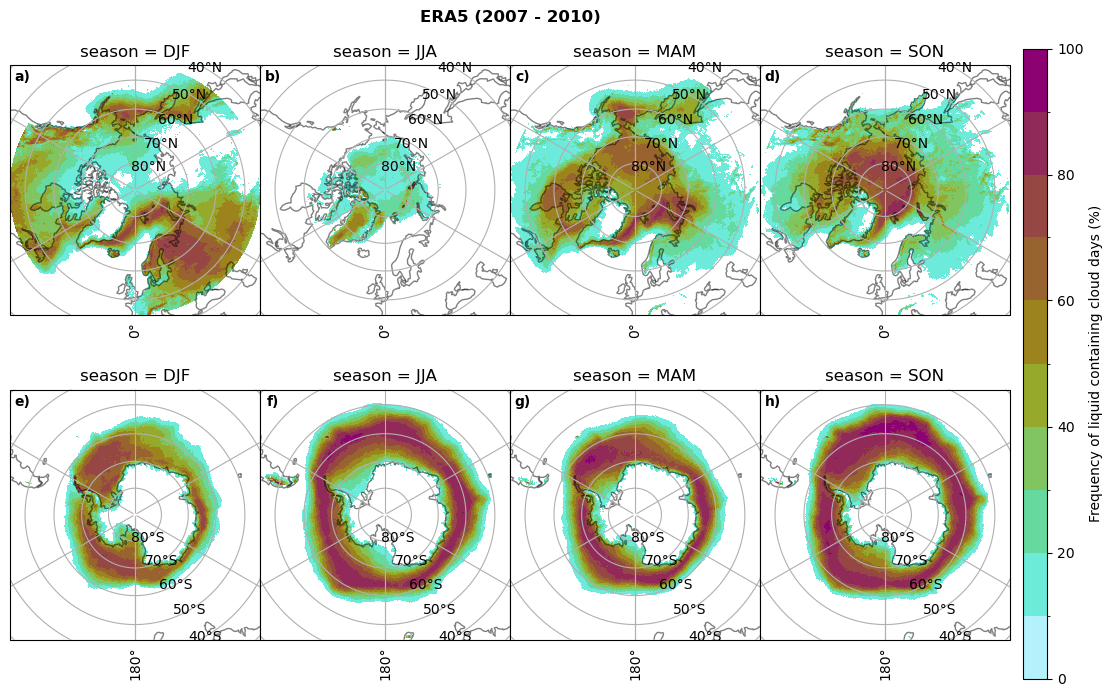

In [26]:
figname = 'cum_lcc_days_season_{}_{}.png'.format(starty, endy)
fct.plt_seasonal_NH_SH((cumm['lcc_days'].where(cumm['lcc_days'] > 0.))*100, levels=np.arange(0,110,10), cbar_label='Frequency of liquid containing cloud days (%)', plt_title='ERA5 ({} - {})'.format(starty,endy), extend=None)
plt.savefig(FIG_DIR + figname, format = 'png', bbox_inches = 'tight', transparent = False)


In [27]:
cumm['sf_days'] = (ds_era_lcc_2t_sf_days['twp'].groupby('time.season').count(dim='time',keep_attrs=False))/days_season
print('min:', cumm['sf_days'].min().round(3).values,
      'max:', cumm['sf_days'].max().round(3).values,  
      'std:', cumm['sf_days'].std(skipna=True).round(3).values, 
      'mean:', cumm['sf_days'].mean(skipna=True).round(3).values)

min: 0.0 max: 0.897 std: 0.218 mean: 0.165


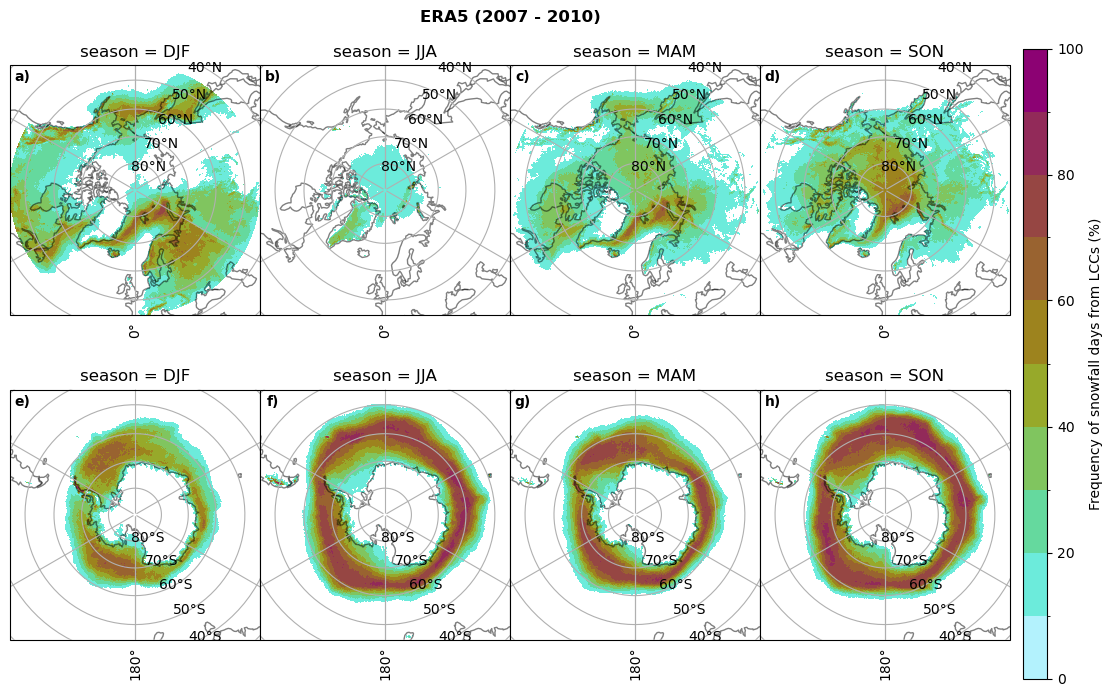

In [28]:
figname = 'cum_sf_days_season_{}_{}.png'.format(starty, endy)
fct.plt_seasonal_NH_SH((cumm['sf_days'].where(cumm['sf_days'] >0.))*100, levels=np.arange(0,110,10), cbar_label='Frequency of snowfall days from LCCs (%)', plt_title='ERA5 ({} - {})'.format(starty,endy), extend=None)
plt.savefig(FIG_DIR + figname, format = 'png', bbox_inches = 'tight', transparent = False)



## Liquid containing cloud frequency

 Relative frequency

$$RF = \frac{f}{n} = \frac{\text{number of times the data occurred in an observation}}{\text{total frequency}}$$

In [29]:
ratios = xr.Dataset()

In [30]:
# relative frequency of liquid containing clouds per season
f = ds_era_lcc_2t_days['lwp'].groupby('time.season').count(dim='time', keep_attrs=False) # number of times a super cooled liquid water cloud occured when the liquid water path is larger than 5gm-2, and temperature below 0degC
n = ds_era_lcc['lwp'].groupby('time.season').count(dim='time', keep_attrs=False)         # frequency of liquid clouds (only LWP threshold applied) when lwp is larger than 5gm-2

ratios['lcc_wo_snow_season'] = f/n

print('min:', ratios['lcc_wo_snow_season'].min().round(3).values,
      'max:', ratios['lcc_wo_snow_season'].max().round(3).values,  
      'std:', ratios['lcc_wo_snow_season'].std(skipna=True).round(3).values, 
      'mean:', ratios['lcc_wo_snow_season'].mean(skipna=True).round(3).values)

min: 0.0 max: 1.0 std: 0.435 mean: 0.435


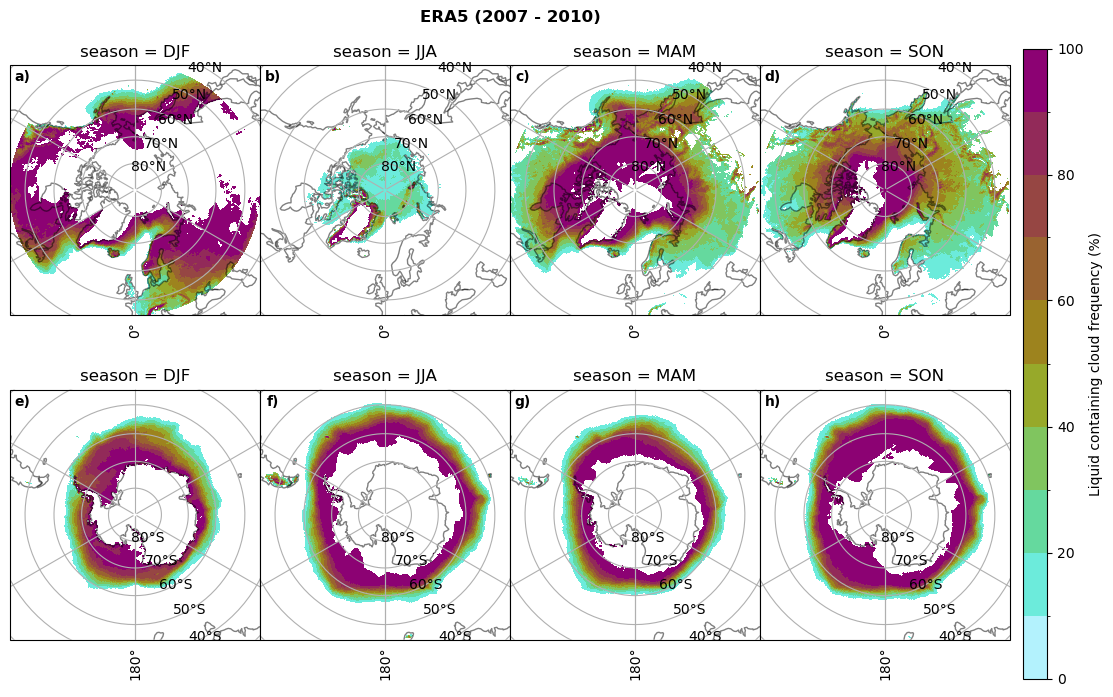

In [31]:
fct.plt_seasonal_NH_SH((ratios['lcc_wo_snow_season'].where(ratios['lcc_wo_snow_season']>0.))*100, np.arange(0,110,10), 'Liquid containing cloud frequency (%)', plt_title='ERA5 ({} - {})'.format(starty,endy), extend=None)

figname = '{}_rf_lcc_wo_snow_season_{}_{}.png'.format('ERA5',starty, endy)
plt.savefig(FIG_DIR + figname, format = 'png', bbox_inches = 'tight', transparent = False)

In [32]:
# relative frequency of liquid containing clouds per month
f = ds_era_lcc_2t_days['lwp'].groupby('time.month').count(dim='time', keep_attrs=False) # number of times a super cooled liquid water cloud occured when the liquid water path is larger than 5gm-2, and temperature below 0degC
n = ds_era_lcc['lwp'].groupby('time.month').count(dim='time', keep_attrs=False)         # frequency of liquid clouds (only LWP threshold applied) when lwp is larger than 5gm-2

ratios['lcc_wo_snow_month'] = f/n

print('min:', ratios['lcc_wo_snow_month'].min().round(3).values,
      'max:', ratios['lcc_wo_snow_month'].max().round(3).values,  
      'std:', ratios['lcc_wo_snow_month'].std(skipna=True).round(3).values, 
      'mean:', ratios['lcc_wo_snow_month'].mean(skipna=True).round(3).values)


min: 0.0 max: 1.0 std: 0.454 mean: 0.452


## Masked and weighted average
Make use of the `xarray` function `weighted`, but calculate the weights with the code above from Luke Gloege.

In [33]:
NH_mean = xr.Dataset()
SH_mean = xr.Dataset()

NH_std = xr.Dataset()
SH_std = xr.Dataset()

# Grid cells have different area, so when we do the global average, they have to be weigted by the area of each grid cell.
weights = fct.area_grid(ratios['lat'].values, ratios['lon'].values)

NH_mean['lcc_wo_snow_month'] = ratios['lcc_wo_snow_month'].sel(lat=slice(45,90)).weighted(weights).mean(('lat', 'lon'))
SH_mean['lcc_wo_snow_month'] = ratios['lcc_wo_snow_month'].sel(lat=slice(-90,-45)).weighted(weights).mean(('lat', 'lon'))

NH_std['lcc_wo_snow_month'] = ratios['lcc_wo_snow_month'].sel(lat=slice(45,90)).weighted(weights).std(('lat', 'lon'))
SH_std['lcc_wo_snow_month'] = ratios['lcc_wo_snow_month'].sel(lat=slice(-90,-45)).weighted(weights).std(('lat', 'lon'))


In [34]:
# for year in np.unique(ds_era['time.year']):
#     # print(year)
#     f = ds_era_lcc_2t_days['lwp'].sel(time=slice(str(year))).groupby('time.month').count(dim='time',keep_attrs=False)
#     n = ds_era_lcc['lwp'].sel(time=slice(str(year))).groupby('time.month').count(dim='time',keep_attrs=False)

#     _ratio = f/n
    
#     NH_mean['lcc_wo_snow_month_'+str(year)] = _ratio.sel(lat=slice(45,90)).weighted(weights).mean(('lat', 'lon'))
#     SH_mean['lcc_wo_snow_month_'+str(year)] = _ratio.sel(lat=slice(-90,-45)).weighted(weights).mean(('lat', 'lon'))
    
#     NH_std['lcc_wo_snow_month_'+str(year)] = _ratio.sel(lat=slice(45,90)).weighted(weights).std(('lat', 'lon'))
#     SH_std['lcc_wo_snow_month_'+str(year)] = _ratio.sel(lat=slice(-90,-45)).weighted(weights).std(('lat', 'lon'))

### Annual cycle of frequency of liquid containing clouds


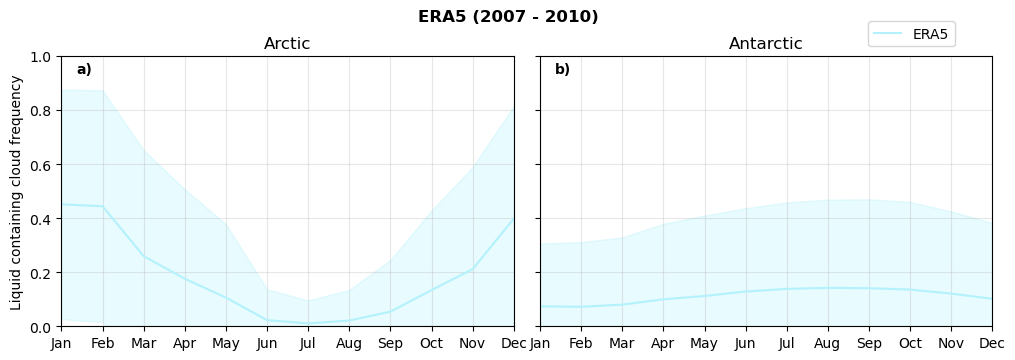

In [35]:
fct.plt_annual_cycle(NH_mean['lcc_wo_snow_month'], SH_mean['lcc_wo_snow_month'], NH_std['lcc_wo_snow_month'], SH_std['lcc_wo_snow_month'], 'Liquid containing cloud frequency','ERA5 ({} - {})'.format(starty,endy))
figname = '{}_rf_lcc_wo_snow_annual_{}_{}.png'.format('ERA5',starty, endy)
plt.savefig(FIG_DIR + figname, format = 'png', bbox_inches = 'tight', transparent = False)

## Frequency of snowfall from LCCs

In [36]:
# relative frequency of snowing liquid containing clouds per season
f = ds_era_lcc_2t_sf_days['msr'].groupby('time.season').count(dim='time', keep_attrs=False)  # number of times a super cooled liquid water cloud occured when the liquid water path is larger than 5gm-2, and temperature below 0degC
n = ds_era_lcc_2t_days['lwp'].groupby('time.season').count(dim='time', keep_attrs=False)

ratios['lcc_w_snow_season'] = f/n
print('min:', ratios['lcc_w_snow_season'].min().round(3).values,
      'max:', ratios['lcc_w_snow_season'].max().round(3).values,  
      'std:', ratios['lcc_w_snow_season'].std(skipna=True).round(3).values, 
      'mean:', ratios['lcc_w_snow_season'].mean(skipna=True).round(3).values)

# 

min: 0.0 max: 1.0 std: 0.254 mean: 0.686


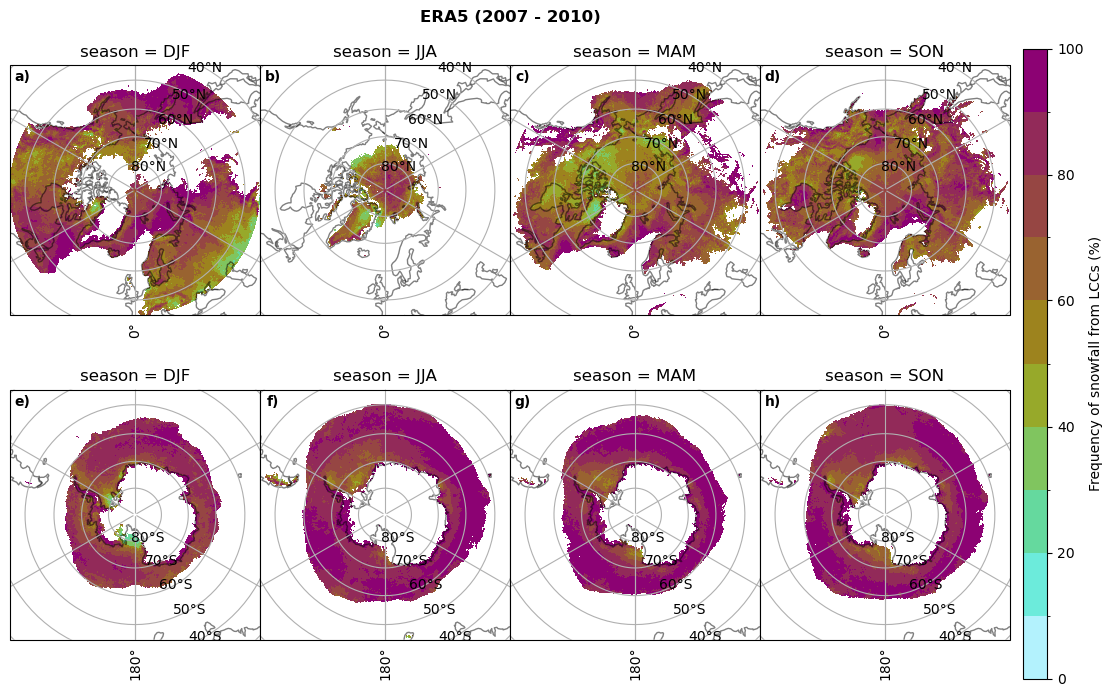

In [37]:
fct.plt_seasonal_NH_SH((ratios['lcc_w_snow_season'].where(ratios['lcc_w_snow_season']>0.))*100, np.arange(0,110,10), 'Frequency of snowfall from LCCs (%)', plt_title='ERA5 ({} - {})'.format(starty,endy), extend=None)

figname = '{}_rf_lcc_w_snow_season_{}_{}.png'.format('ERA5',starty, endy)
plt.savefig(FIG_DIR + figname, format = 'png', bbox_inches = 'tight', transparent = False)

In [38]:
# relative frequency of liquid containing clouds per month
f = ds_era_lcc_2t_sf_days['msr'].groupby('time.month').count(dim='time', keep_attrs=False) # number of times a super cooled liquid water cloud occured when the liquid water path is larger than 5gm-2, and temperature below 0degC
n = ds_era_lcc_2t_days['lwp'].groupby('time.month').count(dim='time', keep_attrs=False)         # frequency of liquid clouds (only LWP threshold applied) when lwp is larger than 5gm-2

ratios['lcc_w_snow_month'] = f/n

print('min:', ratios['lcc_w_snow_month'].min().round(3).values,
      'max:', ratios['lcc_w_snow_month'].max().round(3).values,  
      'std:', ratios['lcc_w_snow_month'].std(skipna=True).round(3).values, 
      'mean:', ratios['lcc_w_snow_month'].mean(skipna=True).round(3).values)


min: 0.0 max: 1.0 std: 0.269 mean: 0.681


In [39]:
# Grid cells have different area, so when we do the global average, they have to be weigted by the area of each grid cell.
weights = fct.area_grid(ratios['lat'].values, ratios['lon'].values)

NH_mean['lcc_w_snow_month'] = ratios['lcc_w_snow_month'].sel(lat=slice(45,90)).weighted(weights).mean(('lat', 'lon'))
SH_mean['lcc_w_snow_month'] = ratios['lcc_w_snow_month'].sel(lat=slice(-90,-45)).weighted(weights).mean(('lat', 'lon'))

NH_std['lcc_w_snow_month'] = ratios['lcc_w_snow_month'].sel(lat=slice(45,90)).weighted(weights).std(('lat', 'lon'))
SH_std['lcc_w_snow_month'] = ratios['lcc_w_snow_month'].sel(lat=slice(-90,-45)).weighted(weights).std(('lat', 'lon'))

### Annual cycle of frequency of snowfall from LCCs

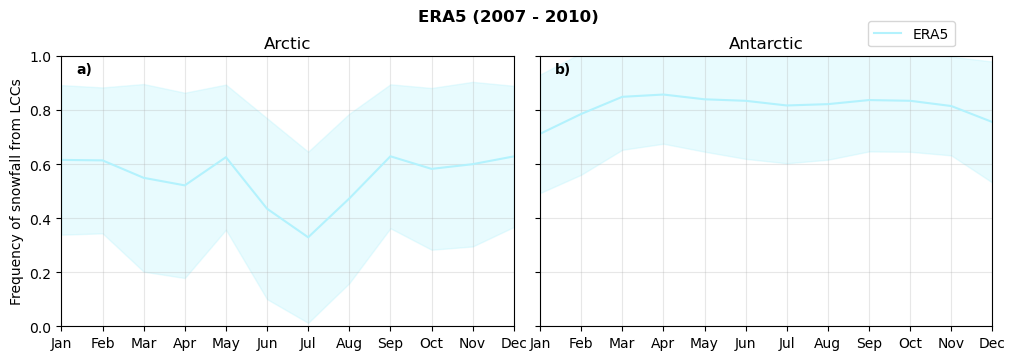

In [40]:
fct.plt_annual_cycle(NH_mean['lcc_w_snow_month'], SH_mean['lcc_w_snow_month'], NH_std['lcc_w_snow_month'], SH_std['lcc_w_snow_month'], 'Frequency of snowfall from LCCs','ERA5 ({} - {})'.format(starty,endy))
# figname = '{}_rf_lcc_wo_snow_annual_{}_{}.png'.format('ERA5',starty, endy)
plt.savefig(FIG_DIR + figname, format = 'png', bbox_inches = 'tight', transparent = False)

## Relative snowfall efficency

The precipitation efficiency of convection is a measure of how much of the water that condenses in a rising column of air reaches the surface as precipitation [3].

In our case, we calculate the snowfall efficency by deviding the mean surface snowfall rate (sf, with units kg m-2 h-1) with the column integrated total water path (TWP, with units kg m-2). This leaves us with units of h-1, which means we get a daily mean relative snowfall efficency per hour. 

$$\eta = \frac{sf}{TWP}$$

min: 0.045 max: 2.762 std: 0.169 mean: 0.546


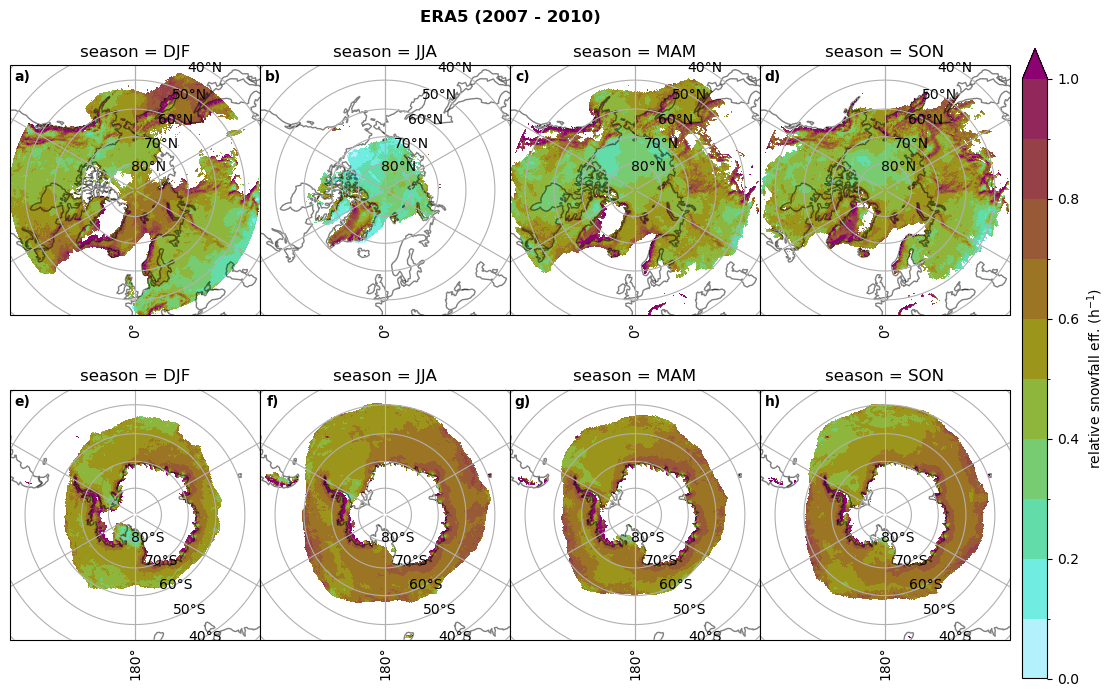

In [41]:
# snowfall efficency per season
# first averavge over time and then fraction remove weighting only for spatial average

ratios['sf_eff_season'] = ds_era_lcc_2t_season['msr']/ds_era_lcc_2t_season['twp']
# plt_seasonal_NH_SH(ds_era_lcc_2t_sf_season['msr']/ds_era_lcc_2t_sf_season['twp'], np.arange(0,1, 0.1),'','')
print('min:', ratios['sf_eff_season'].min().round(3).values,
      'max:', ratios['sf_eff_season'].max().round(3).values,  
      'std:', ratios['sf_eff_season'].std(skipna=True).round(3).values, 
      'mean:', ratios['sf_eff_season'].mean(skipna=True).round(3).values)

fct.plt_seasonal_NH_SH(ratios['sf_eff_season'].where(ratios['sf_eff_season']>0.), np.arange(0,1.1,0.1), 'relative snowfall eff. (h$^{-1}$)', 'ERA5 ({} - {})'.format(starty,endy), extend='max')
# save precip efficency from mixed-phase clouds figure
figname = '{}_sf_twp_season_{}_{}.png'.format('ERA5', starty, endy)
plt.savefig(FIG_DIR + figname, format = 'png', bbox_inches = 'tight', transparent = False)

### Annual cycle of relative snowfall efficency


min: 0.0 max: 7.405 std: 0.24 mean: 0.571


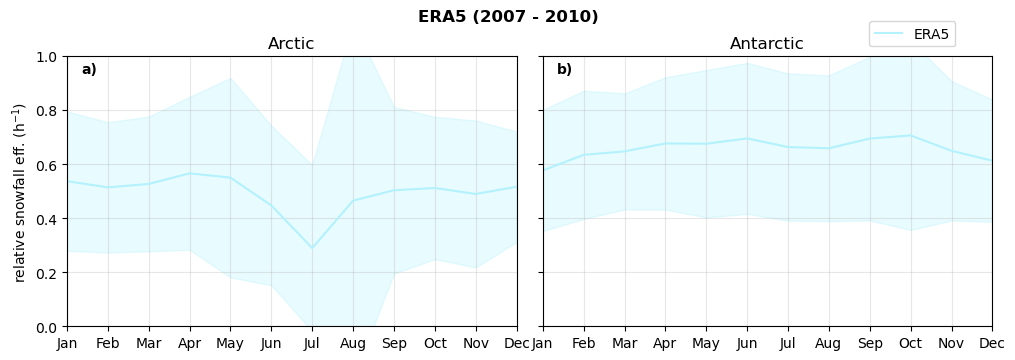

In [42]:
# shouldn't it be the mean not the sum?
f = ds_era_lcc_2t['msr'].groupby('time.month').sum(dim='time', skipna=True, keep_attrs=False)
n = ds_era_lcc_2t['twp'].groupby('time.month').sum(dim='time', skipna=True, keep_attrs=False)
ratios['sf_eff_month'] = f/n
NH_mean['sf_eff_month'] = ratios['sf_eff_month'].sel(lat=slice(45,90)).weighted(weights).mean(('lat', 'lon'))
SH_mean['sf_eff_month'] = ratios['sf_eff_month'].sel(lat=slice(-90,-45)).weighted(weights).mean(('lat', 'lon'))

NH_std['sf_eff_month'] = ratios['sf_eff_month'].sel(lat=slice(45,90)).weighted(weights).std(('lat', 'lon'))
SH_std['sf_eff_month'] = ratios['sf_eff_month'].sel(lat=slice(-90,-45)).weighted(weights).std(('lat', 'lon'))

print('min:', ratios['sf_eff_month'].min().round(3).values,
      'max:', ratios['sf_eff_month'].max().round(3).values,  
      'std:', ratios['sf_eff_month'].std(skipna=True).round(3).values, 
      'mean:', ratios['sf_eff_month'].mean(skipna=True).round(3).values)

# for year in np.unique(ds_era['time.year']):
#     # print(year)
#     f = ds_era_lcc_2t['msr'].sel(time=slice(str(year))).groupby('time.month').sum(dim='time', skipna=True, keep_attrs=False)
#     n = ds_era_lcc_2t['twp'].sel(time=slice(str(year))).groupby('time.month').sum(dim='time', skipna=True, keep_attrs=False)

#     _ratio = f/n
    
#     NH_mean['sf_eff_month_'+str(year)] = _ratio.sel(lat=slice(45,90)).weighted(weights).mean(('lat', 'lon'))
#     SH_mean['sf_eff_month_'+str(year)] = _ratio.sel(lat=slice(-90,-45)).weighted(weights).mean(('lat', 'lon'))
    
#     NH_std['sf_eff_month_'+str(year)] = _ratio.sel(lat=slice(45,90)).weighted(weights).std(('lat', 'lon'))
#     SH_std['sf_eff_month_'+str(year)] = _ratio.sel(lat=slice(-90,-45)).weighted(weights).std(('lat', 'lon'))

fct.plt_annual_cycle(NH_mean['sf_eff_month'], SH_mean['sf_eff_month'], NH_std['sf_eff_month'], SH_std['sf_eff_month'], 'relative snowfall eff. (h$^{-1}$)', 'ERA5 ({} - {})'.format(starty,endy))
figname = '{}_sf_twp_annual_{}_{}.png'.format('ERA5',starty, endy)
plt.savefig(FIG_DIR + figname, format = 'png', bbox_inches = 'tight', transparent = False)

## Relative precipitation efficency

Use of total precipitation, but where LWP $\ge$ 0.005 gm-2, 2-meter temperature $\le$ 273.15K.


min: 0.073 max: 2.841 std: 0.167 mean: 0.563


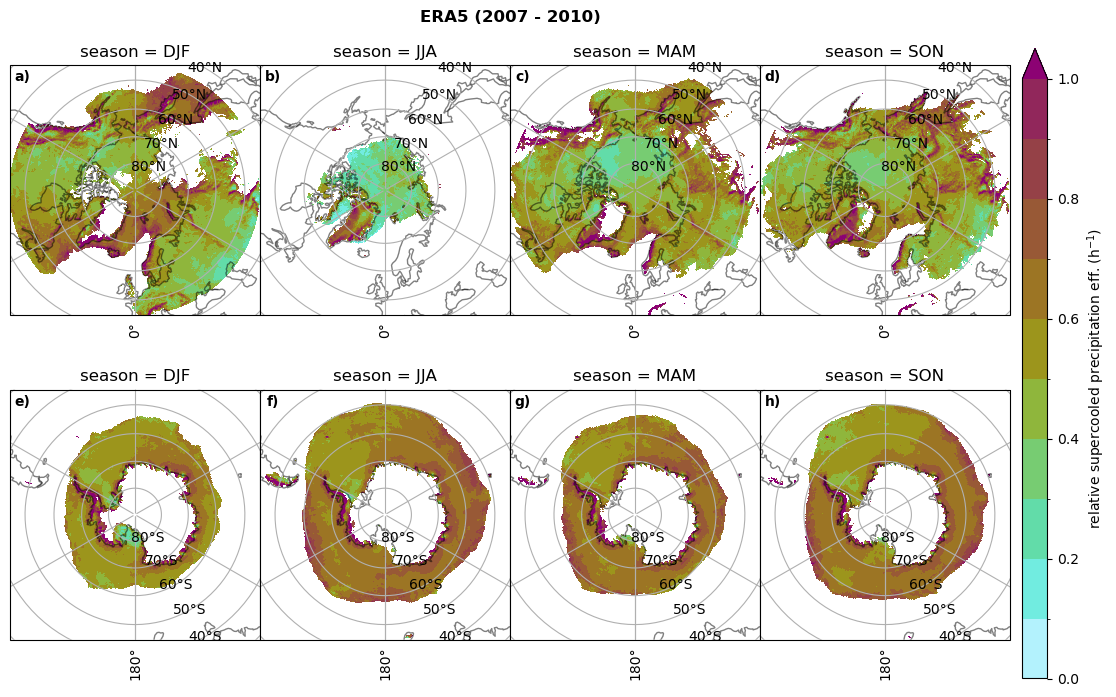

In [43]:
# supercooled precipitation efficency per season
# first averavge over time and then fraction remove weighting only for spatial average

ratios['tp_eff_season'] = ds_era_lcc_2t_season['mtpr']/ds_era_lcc_2t_season['twp']
# plt_seasonal_NH_SH(ds_era_lcc_2t_tp_season['msr']/ds_era_lcc_2t_tp_season['twp'], np.arange(0,1, 0.1),'','')
print('min:', ratios['tp_eff_season'].min().round(3).values,
      'max:', ratios['tp_eff_season'].max().round(3).values,  
      'std:', ratios['tp_eff_season'].std(skipna=True).round(3).values, 
      'mean:', ratios['tp_eff_season'].mean(skipna=True).round(3).values)

# Plot precipitation efficency

fct.plt_seasonal_NH_SH(ratios['tp_eff_season'].where(ratios['tp_eff_season'] >0.), np.arange(0,1.1,0.1), 'relative supercooled precipitation eff. (h$^{-1}$)', 'ERA5 ({} - {})'.format(starty,endy), extend='max')
# save precip efficency from mixed-phase clouds figure
figname = '{}_tp_twp_season_{}_{}.png'.format('ERA5', starty, endy)
plt.savefig(FIG_DIR + figname, format = 'png', bbox_inches = 'tight', transparent = False)

### Annual cycle of relative supercooled precipitation efficency


min: 0.0 max: 7.503 std: 0.244 mean: 0.588


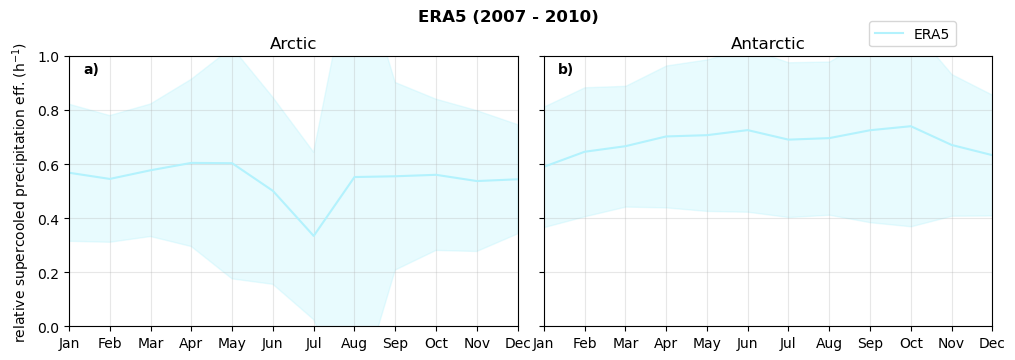

In [44]:
f = ds_era_lcc_2t['mtpr'].groupby('time.month').sum(dim='time', skipna=True, keep_attrs=False)
n = ds_era_lcc_2t['twp'].groupby('time.month').sum(dim='time', skipna=True, keep_attrs=False)
ratios['tp_eff_month'] = f/n
NH_mean['tp_eff_month'] = ratios['tp_eff_month'].sel(lat=slice(45,90)).weighted(weights).mean(('lat', 'lon'))
SH_mean['tp_eff_month'] = ratios['tp_eff_month'].sel(lat=slice(-90,-45)).weighted(weights).mean(('lat', 'lon'))

NH_std['tp_eff_month'] = ratios['tp_eff_month'].sel(lat=slice(45,90)).weighted(weights).std(('lat', 'lon'))
SH_std['tp_eff_month'] = ratios['tp_eff_month'].sel(lat=slice(-90,-45)).weighted(weights).std(('lat', 'lon'))

print('min:', ratios['tp_eff_month'].min().round(3).values,
      'max:', ratios['tp_eff_month'].max().round(3).values,  
      'std:', ratios['tp_eff_month'].std(skipna=True).round(3).values, 
      'mean:', ratios['tp_eff_month'].mean(skipna=True).round(3).values)
# for year in np.unique(ds_era['time.year']):
#     # print(year)
#     f = ds_era_lcc_2t['mtpr'].sel(time=slice(str(year))).groupby('time.month').sum(dim='time', skipna=True, keep_attrs=False)
#     n = ds_era_lcc_2t['twp'].sel(time=slice(str(year))).groupby('time.month').sum(dim='time', skipna=True, keep_attrs=False)

#     _ratio = f/n
    
#     NH_mean['tp_eff_month_'+str(year)] = _ratio.sel(lat=slice(45,90)).weighted(weights).mean(('lat', 'lon'))
#     SH_mean['tp_eff_month_'+str(year)] = _ratio.sel(lat=slice(-90,-45)).weighted(weights).mean(('lat', 'lon'))
    
#     NH_std['tp_eff_month_'+str(year)] = _ratio.sel(lat=slice(45,90)).weighted(weights).std(('lat', 'lon'))
#     SH_std['tp_eff_month_'+str(year)] = _ratio.sel(lat=slice(-90,-45)).weighted(weights).std(('lat', 'lon'))

fct.plt_annual_cycle(NH_mean['tp_eff_month'], SH_mean['tp_eff_month'], NH_std['tp_eff_month'], SH_std['tp_eff_month'], 'relative supercooled precipitation eff. (h$^{-1}$)', 'ERA5 ({} - {})'.format(starty,endy))
figname = '{}_tp_twp_annual_{}_{}.png'.format('ERA5',starty, endy)
plt.savefig(FIG_DIR + figname, format = 'png', bbox_inches = 'tight', transparent = False)

## Frequency of freezing rain 
Use of the thresholds. 

$$RF = \frac{\text{total precipitation}(T\le273.15; LWP\ge0.005gm^{-2}) - \text{snowfall}(T\le273.15; LWP\ge0.005gm^{-2})}{\text{total precipitation}(T\le273.15; LWP\ge0.005gm^{-2})}$$

min: 0.079 max: 1.0 std: 0.136 mean: 0.574


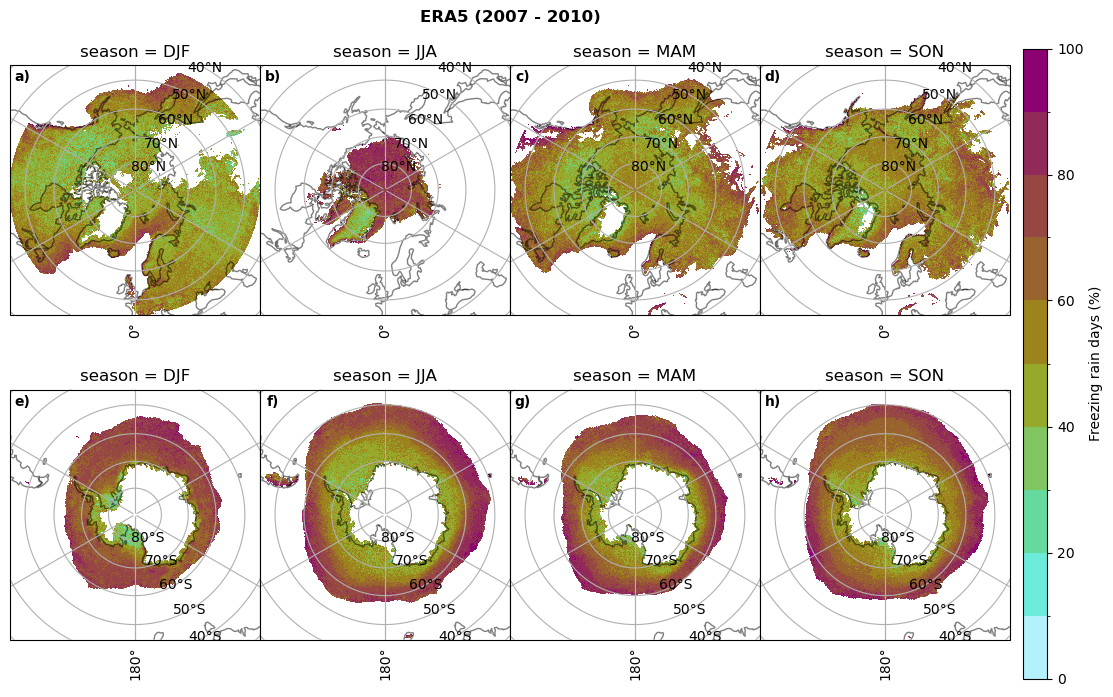

In [45]:
# first count the days where we have freezing rain per season and relate to total precipitation days
fr_d = ds_era_lcc_2t_days['mfrr'].where(ds_era_lcc_2t_days['mfrr']>0.).groupby('time.season').count('time',keep_attrs=False)
tp_d = ds_era_lcc_2t_days['mtpr'].where(ds_era_lcc_2t_days['mtpr']>0.).groupby('time.season').count('time',keep_attrs=False)

ratios['mfrr_mtpr_days'] = fr_d/tp_d

print('min:', ratios['mfrr_mtpr_days'].min().round(3).values,
      'max:', ratios['mfrr_mtpr_days'].max().round(3).values,  
      'std:', ratios['mfrr_mtpr_days'].std(skipna=True).round(3).values, 
      'mean:', ratios['mfrr_mtpr_days'].mean(skipna=True).round(3).values)

fct.plt_seasonal_NH_SH(ratios['mfrr_mtpr_days'].where(ratios['mfrr_mtpr_days']>0)*100, np.arange(0,110,10), 'Freezing rain days (%)', 'ERA5 ({} - {})'.format(starty,endy), extend=None)
figname = '{}_mfrr_mtpr_days_{}_{}.png'.format('ERA5',starty, endy)
plt.savefig(FIG_DIR + figname, format = 'png', bbox_inches = 'tight', transparent = False)



min: 0.0 max: 0.61 std: 0.05 mean: 0.043


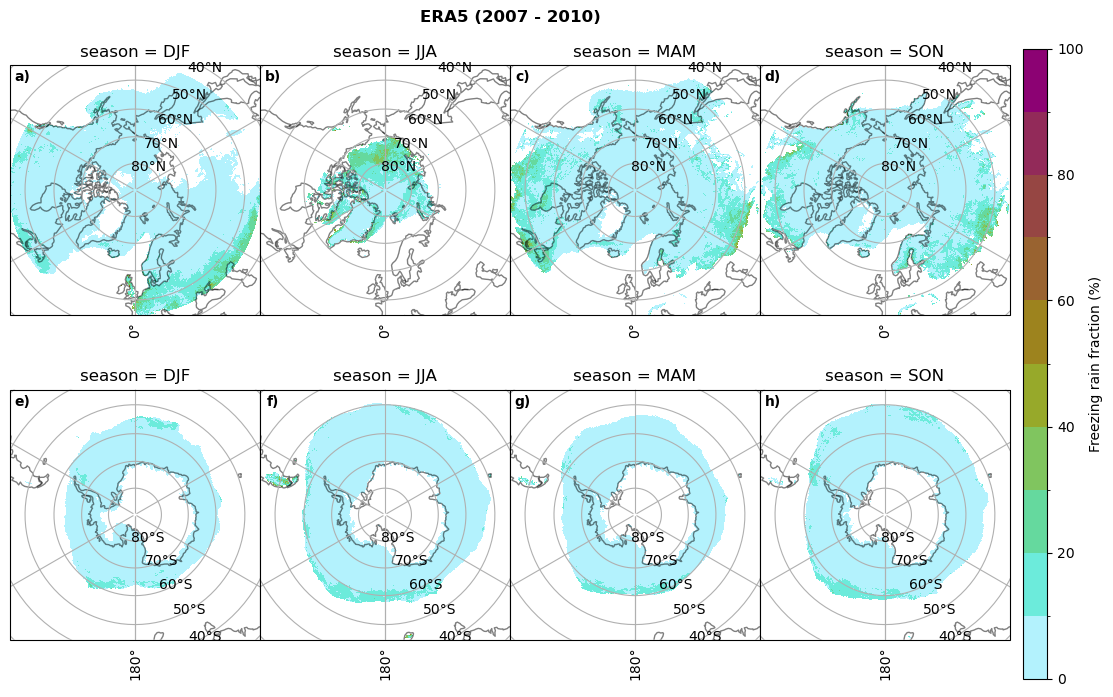

In [46]:
# then bring the amount of freezing rain into relation to the total precipitation (How many percent is freezing rain in comparison to total precipitation)
fr = ds_era_lcc_2t_days['mfrr'].where(ds_era_lcc_2t_days['mfrr']>0.)
tp = ds_era_lcc_2t_days['mtpr'].where(ds_era_lcc_2t_days['mtpr']>0.)

ratios['mfrr_mtpr_frac'] = (fr/tp).groupby('time.season').mean('time',skipna=True,keep_attrs=False)
print('min:', ratios['mfrr_mtpr_frac'].min().round(3).values,
      'max:', ratios['mfrr_mtpr_frac'].max().round(3).values,  
      'std:', ratios['mfrr_mtpr_frac'].std(skipna=True).round(3).values, 
      'mean:', ratios['mfrr_mtpr_frac'].mean(skipna=True).round(3).values)

fct.plt_seasonal_NH_SH(ratios['mfrr_mtpr_frac'].where(ratios['mfrr_mtpr_frac']>0)*100, np.arange(0,110,10), 'Freezing rain fraction (%)', 'ERA5 ({} - {})'.format(starty,endy), extend=None)
figname = '{}_mfrr_mtpr_amount_season_{}_{}.png'.format('ERA5',starty, endy)
plt.savefig(FIG_DIR + figname, format = 'png', bbox_inches = 'tight', transparent = False)



file written: /scratch/franzihe/output/ERA5/daily_means/model_grid/ERA5_daily_mean_ERA5_200701_201012.nc
prsn True
pr True
tas True
iwp True
lwp True
twp True
prsn True
pr True
tas True
iwp True
lwp True
twp True
file written: /scratch/franzihe/output/ERA5/daily_means/model_grid/ERA5_daily_mean_MIROC6_200601_200912.nc
prsn True
pr True
tas True
iwp True
lwp True
twp True
prsn True
pr True
tas True
iwp True
lwp True
twp True
file written: /scratch/franzihe/output/ERA5/daily_means/model_grid/ERA5_daily_mean_CESM2_200601_200912.nc
prsn True
pr True
tas True
iwp True
lwp True
twp True
prsn True
pr True
tas True
iwp True
lwp True
twp True
file written: /scratch/franzihe/output/ERA5/daily_means/model_grid/ERA5_daily_mean_CanESM5_200601_200912.nc
prsn True
pr True
tas True
iwp True
lwp True
twp True
prsn True
pr True
tas True
iwp True
lwp True
twp True
file written: /scratch/franzihe/output/ERA5/daily_means/model_grid/ERA5_daily_mean_AWI-ESM-1-1-LR_200601_200912.nc
prsn True
pr True
tas True


# Way to Average the Globe 
Code and text taken from Luke Gloege at https://towardsdatascience.com/the-correct-way-to-average-the-globe-92ceecd172b7 

"The average. It’s a simple enough calculation: add up all your data points and divide by the total number points. Does this simple equation work if you are, for instance, calculating the global average temperature? Not quite. This post outlines how to calculate the global average of a gridded dataset with dimensions: `time`, `latitude`, and `longitude`. In other words, calculating the mean across `latitude` and `longitude` at each `time` step. I first explain why it is not appropriate to calculate the spatial mean of a variable using the classic formula, I then show why a weighted-mean is appropriate, and finally give an example using a publicly available dataset.

**The traditional mean** 
The equation below is what probably comes to mind when we think of the mean of a dataset, `X`. This is the traditional mean. In the equation, i represents each `latitude`, `longitude` coordinate pair and `N` is the total number pairs.

$mean = \frac{\sum_{i=1}^N X_i}{N}$


I also call this the “flat Earth mean,” it assumes no curvature to the planet and data at each latitude and longitude location is treated equally. Why is that important? Because a 1º x 1º grid box occupies less area as it moves from the tropics to the pole. What this means is data near the equator has more influence on the mean than the arctic because it occupies more area. This suggests we should weight each data point by the area it occupies.

In `xarray` notation, this traditional or “flat Earth” mean can be calculated like this: `traditional_mean = ds['temperature'].mean(['latitude','longitude'])`

**The weighted mean**

This is the general equation for a weighted mean:

$\text{weighted mean} = \frac{\sum_{i=1}^N w_i X_i}{\sum_{i=1}^N w_i}$

This is similar to the traditional mean, except each data point has a weight, `wi`, and the denominator is the sum of all the weights. The traditional mean is just a special case of the weighted mean where each weight is equal to 1.

**Calculating the global area**

In Earth science, the preferred way is to weight the data by area, where you weight each data point by the area of each grid cell. Before we calculate the area-weighted mean, we first need to know the area of each grid cell. If the grid cell area is not provided the code below will facilitate calculating an area grid.

The shape of the Earth is an oblate spheroid, which is like “squashed” sphere. The code below calculates the grid cell area for Earth, with the radius as a function of latitude from [World Geodetic System 1984](https://earth-info.nga.mil/GandG/publications/tr8350.2/tr8350.2-a/Chapter%203.pdf). A derivation of the equation is [here](https://planetcalc.com/7721/).


**Area weighted global mean**

Now that we know what a weighted mean is and how to calculate an area map, let’s put all of this information together and calculate the global average mean temperature anomaly using the code below.
```
# area dataArray
da_area = area_grid(ds['latitude'], ds['longitude'])

# total area
total_area = da_area.sum(['latitude','longitude'])

# temperature weighted by grid-cell area
temp_weighted = (ds['temperature']*da_area) / total_area

# area-weighted mean temperature
temp_weighted_mean = temp_weighted.sum(['latitude','longitude'])
```


**Final thoughts**

Weighting your data when calculating geospatial means is not just important, it is required in or order to honestly display the average and not overstate a conclusion.

Here are a few things to be mindful of when calculating global averages:

1. Be mindful of the total area. If you are calculating global average temperature just on land, then you need to mask out the ocean in your area dataset and normalize the weights by the total land area.
2. If the dataset is spatially incomplete, sophisticated methods [2] are more appropriate.

In summary, area-weighting is the correct and best way to calculate global averages if you have a spatially complete gridded dataset. However, advanced techniques are required if the gridded data contains gaps. Finally, an alternative approach is to cosine weight your data, i.e. weighting your data by the cosine of latitude. The concept is the same, instead of using grid cell area, you would use the `cos('latitude')` as your weight matrix.

Hopefully this post provides some helpful guidance when calculating global averages.



## Calculating bin and bin sizes
https://www.statisticshowto.com/choose-bin-sizes-statistics/

Useful to plot TWP vs. Snowfall (precipitation efficency)

1. Find the smallest and largest data point

In [ ]:
## Python program to print the data

d = {'twp_NH': [(ds_era_lcc_sf_2t['twp'].where(ds_era_lcc_sf_2t['lat']>=45).min().round(4)).values, (ds_era_lcc_sf_2t['twp'].where(ds_era_lcc_sf_2t['lat']>=45).max().round(4)).values, 'NH'],
     'sf_NH': [(ds_era_lcc_sf_2t['msr'].where(ds_era_lcc_sf_2t['lat']>=45).min().round(4)).values, (ds_era_lcc_sf_2t['msr'].where(ds_era_lcc_sf_2t['lat']>=45).max().round(4)).values, 'NH'],
     'twp_SH': [(ds_era_lcc_sf_2t['twp'].where(ds_era_lcc_sf_2t['lat']<=-45).min().round(4)).values, (ds_era_lcc_sf_2t['twp'].where(ds_era_lcc_sf_2t['lat']<=-45).max().round(4)).values, 'SH'],
     'sf_SH': [(ds_era_lcc_sf_2t['msr'].where(ds_era_lcc_sf_2t['lat']>=-45).min().round(4)).values, (ds_era_lcc_sf_2t['msr'].where(ds_era_lcc_sf_2t['lat']<=-45).max().round(4)).values, 'SH'],  
}
print ("{:<8} {:<10} {:<10} {:<10}".format('Var','min','max','Hemisphere'))
for k, v in d.items():
    lang, perc, change = v
    print ("{:<8} {:<10.4f} {:<10.4f} {:<10}".format(k, lang, perc, change))


2. Smallest and/or largest numbers are not whole numbers $\rightarrow$ Lower the minimum a little and raise the maximum a little

|     | Min   |Max    |Diff   |Hemisphere|
| ----|:-----:|:-----:|:-----:|---------:|
| TWP | 0.006 | 7.1   | 7.1   |NH       |  
| sf  | 0.01  | 6.5   | 6.5   |NH       |
| ----|-------|-------|-------|---------|
| TWP | 0.006 | 4.7   | 4.7   |NH       |  
| sf  | 0.01  | 4.3   | 4.3   |NH       |

3. Decide how many bins you need

|     | Min   |Max    |Diff   |Bins   |Hemisphere|
| ----|:-----:|:-----:|:-----:|:-----:|---------:|
| TWP | 0.006 | 7.1   | 7.1   |80     |NH       |  
| sf  | 0.01  | 6.5   | 6.5   |70     |NH       |
| ----|-------|-------|-------|-------|---------|
| TWP | 0.006 | 4.7   | 4.7   |50     |NH       |  
| sf  | 0.01  | 4.3   | 4.3   |50     |NH       |

4. Divide your range (the numbers in your data set) by the bin size chosen in Step 3. E.g. numbers range from 0 to 50 $\rightarrow$ choose 5 bins $\rightarrow$ bin size is 50/5=10.

|     | Min   |Max    |Diff   |Bins   |Bin size |Hemisphere|
| ----|:-----:|:-----:|:-----:|:-----:|:-------:|---------:|
| TWP | 0.005 | 7.1   | 7.1   |80     |8/80=0.1 |NH       |  
| sf  | 0.01  | 6.5   | 6.5   |70     |7/70=0.1 |NH       |
| ----|-------|-------|-------|-------|---------|---------|
| TWP | 0.006 | 4.7   | 4.7   |50     |5/50=0.1 |NH       |  
| sf  | 0.01  | 105   | 4.3   |50     |5/50=0.1 |NH       |


5. Create the bin boundaries, starting with the smallest number (Step 1, 2) and adding the bin size from Step 4. E.g. smallest number is 0, bin size = 10 $\rightarrow$ boundaries 0, 10,20,...


## Snowfall and Precipitation efficency

In [ ]:
def plt_seasonal_2dhist_wp_sf(da_x, da_y, plt_title, xlabel, ylabel):
    f, axsm = plt.subplots(nrows=2,ncols=4,figsize =[10,5], sharex=True, sharey=True)
    # cmap = cm.batlow
    cmap = cm.hawaii_r
    # levels = np.arange(0.1,65000,5000)
    # norm = BoundaryNorm(levels, ncolors=cmap.N, )
    norm = LogNorm(vmin=1, vmax=50000)

    ax = axsm.flatten()[0]


    for ax, season in zip(axsm.flatten()[:4], da_x['season'].values):
        ax.plot([0, 1], [0, 1],ls="--", c=".6", transform=ax.transAxes)
        x_value = da_x.sel(season=season, lat=slice(45,90)).values.flatten()        
        y_value = da_y.sel(season=season, lat=slice(45,90)).values.flatten()   
        Z, xedges, yedges = np.histogram2d(x_value[(~np.isnan(x_value)) & (~np.isnan(y_value))],
                                        y_value[(~np.isnan(x_value)) & (~np.isnan(y_value))],
                                        bins=[80, 80], 
                                        range=[[0,8],[0, 8]])
        
        im = ax.pcolormesh(xedges, yedges, Z.transpose(),cmap=cmap,norm=norm,)
        # cbar = f.colorbar(im, ax=ax,)
        ax.set(title =r'lat$\geq 45^\circ$N; season = {}'.format(season))
        ax.grid()
        
        _corr = _corr = xr.corr(da_x.sel(season=season, lat=slice(45,90)), 
                                da_y.sel(season=season, lat=slice(45,90)))
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.55, 0.95, 'Corr: {}'.format(np.round(_corr,3).values), transform=ax.transAxes, fontsize=11,
                verticalalignment='top', bbox=props)
        
        #find line of best fit
        a, b = np.polyfit(x_value[(~np.isnan(x_value)) & (~np.isnan(y_value))], y_value[(~np.isnan(x_value)) & (~np.isnan(y_value))], 1)
        #add line of best fit to plot
        ax.plot(x_value[(~np.isnan(x_value)) & (~np.isnan(y_value))], a*(x_value[(~np.isnan(x_value)) & (~np.isnan(y_value))])+b, color='steelblue', linestyle='--', linewidth=2)
        #add fitted regression equation to plot
        ax.text(1, 0.17, 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=14)

        
        
    for ax, season in zip(axsm.flatten()[4:], da_x['season'].values):
        ax.plot([0, 1], [0, 1],ls="--", c=".6", transform=ax.transAxes)
        x_value = da_x.sel(season=season, lat=slice(-90,-45)).values.flatten()
        y_value = da_y.sel(season=season, lat=slice(-90,-45)).values.flatten()
        Z, xedges, yedges = np.histogram2d(x_value[(~np.isnan(x_value)) & (~np.isnan(y_value))],
                                        y_value[(~np.isnan(x_value)) & (~np.isnan(y_value))],
                                        bins=[80, 80], 
                                        range=[[0,8],[0, 8]])
        
        im = ax.pcolormesh(xedges, yedges, Z.transpose(),cmap=cmap,norm=norm,)
        # cbar = f.colorbar(im, ax=ax, )
        ax.set(title =r'lat$\leq-45^\circ$S; season = {}'.format(season))
            
        ax.set_xlabel('{} ({})'.format(xlabel,da_x.attrs['units']))
        ax.grid()
        
        
        _corr = xr.corr(da_x.sel(season=season, lat=slice(-90,45)),
                        da_y.sel(season=season, lat=slice(-90,45)))
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.55, 0.95, 'Corr: {}'.format(np.round(_corr,3).values), transform=ax.transAxes, fontsize=11,
                verticalalignment='top', bbox=props)
        
        #find line of best fit
        a, b = np.polyfit(x_value[(~np.isnan(x_value)) & (~np.isnan(y_value))], y_value[(~np.isnan(x_value)) & (~np.isnan(y_value))], 1)
        #add line of best fit to plot
        ax.plot(x_value[(~np.isnan(x_value)) & (~np.isnan(y_value))], a*(x_value[(~np.isnan(x_value)) & (~np.isnan(y_value))])+b, color='steelblue', linestyle='--', linewidth=2)
        #add fitted regression equation to plot
        ax.text(1, 0.17, 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=14)

        
    axsm.flatten()[0].set_ylabel('{} ({})'.format(ylabel, da_y.attrs['units']))
    axsm.flatten()[4].set_ylabel('{} ({})'.format(ylabel, da_y.attrs['units']))


    cbaxes = f.add_axes([1.0125, 0.025, 0.025, 0.9])
    cbar = plt.colorbar(im, cax=cbaxes, shrink=0.5, orientation='vertical', label='Frequency')
    f.suptitle(plt_title, fontweight="bold");
        
        
        
    plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=0.5)


In [ ]:
# precip efficency from ice
da_x = seasonal_lcc_sf_2t['iwp']
da_y = seasonal_lcc_sf_2t['msr']
xlabel='Ice Water Path'
ylabel='Snowfall'
plt_title = 'ERA5 ({} - {}) Seasonal ice snowfall efficency'.format(starty,endy)

figname = '2dhist_iwp_sf_season_{}_{}.png'.format(starty, endy)
plt_seasonal_2dhist_wp_sf(da_x, da_y, plt_title, xlabel, ylabel)
plt.savefig(FIG_DIR + figname, format = 'png', bbox_inches = 'tight', transparent = False)

######################################
# precip efficency from liquid
da_x = seasonal_lcc_sf_2t['lwp']
da_y = seasonal_lcc_sf_2t['msr']
xlabel='Liquid Water Path'
ylabel='Snowfall'
plt_title = 'ERA5 ({} - {}) Seasonal liquid snowfall efficency'.format(starty,endy)

figname = '2dhist_lwp_sf_season_{}_{}.png'.format(starty, endy)
plt_seasonal_2dhist_wp_sf(da_x, da_y, plt_title, xlabel, ylabel)
plt.savefig(FIG_DIR + figname, format = 'png', bbox_inches = 'tight', transparent = False)

######################################
# precip efficency from mixed-phase clouds
da_x = seasonal_lcc_sf_2t['twp']
da_y = seasonal_lcc_sf_2t['msr']
xlabel='Total Water Path'
ylabel='Snowfall'
plt_title = 'ERA5 ({} - {}) Seasonal total snowfall efficency'.format(starty,endy)

figname = '2dhist_lwp_iwp_sf_season_{}_{}.png'.format(starty, endy)
plt_seasonal_2dhist_wp_sf(da_x, da_y, plt_title, xlabel, ylabel)
plt.savefig(FIG_DIR + figname, format = 'png', bbox_inches = 'tight', transparent = False)


In [ ]:
# precip efficency from ice
da_x = seasonal_lcc_2t['iwp']
da_y = seasonal_lcc_2t['mtpr']
xlabel='Ice Water Path'
ylabel='Snowfall'
plt_title = 'ERA5 ({} - {}) Seasonal ice precipitation efficency'.format(starty,endy)

figname = '2dhist_iwp_tp_season_{}_{}.png'.format(starty, endy)
plt_seasonal_2dhist_wp_sf(da_x, da_y, plt_title, xlabel, ylabel)
plt.savefig(FIG_DIR + figname, format = 'png', bbox_inches = 'tight', transparent = False)

######################################
# precip efficency from liquid
da_x = seasonal_lcc_2t['lwp']
da_y = seasonal_lcc_2t['mtpr']
xlabel='Liquid Water Path'
ylabel='Snowfall'
plt_title = 'ERA5 ({} - {}) Seasonal liquid precipitation efficency'.format(starty,endy)

figname = '2dhist_lwp_tp_season_{}_{}.png'.format(starty, endy)
plt_seasonal_2dhist_wp_sf(da_x, da_y, plt_title, xlabel, ylabel)
plt.savefig(FIG_DIR + figname, format = 'png', bbox_inches = 'tight', transparent = False)

######################################
# precip efficency from mixed-phase clouds
da_x = seasonal_lcc_2t['twp']
da_y = seasonal_lcc_2t['mtpr']
xlabel='Total Water Path'
ylabel='Snowfall'
plt_title = 'ERA5 ({} - {}) Seasonal total precipitation efficency'.format(starty,endy)

figname = '2dhist_lwp_iwp_tp_season_{}_{}.png'.format(starty, endy)
plt_seasonal_2dhist_wp_sf(da_x, da_y, plt_title, xlabel, ylabel)
plt.savefig(FIG_DIR + figname, format = 'png', bbox_inches = 'tight', transparent = False)


In [ ]:
# Regrid data
SH = ds_era.sel(lat=slice(-90,-45))
NH = ds_era.sel(lat=slice(45,90))
    
era_con = xr.concat([SH, NH], 'lat')

filename = 'ERA5_daily_mean_{}_{}01_{}12.nc'.format('ERA5',starty, endy)
era_file_out = os.path.join(era_out, 'model_grid/' +filename)

try:
    os.mkdir(os.path.join(era_out, 'model_grid'))
except OSError:
    pass

counter = 0
files = glob(era_file_out)
if era_file_out in files:
    print('{} is downloaded'.format(era_file_out))
    counter += 1
    print('Have regridded in total: {:} files'.format(str(counter))) 
else: # Save to netcdf file
    era_con.to_netcdf(era_file_out)
    print('file written: {}'.format(era_file_out))
    

## Mask atmopsheric temperature

During the process of finding the SLF50, SLF30, SLF70 we encountered the problem, that the atmospheric temperature is too cold with $T<175K$. To avoid cold temperatures we will mask the atmospheric temperature values. For this we will try a few thresholds and see how it looks on a spatial map, if we are masking too many temperatures then we know that our threshold is too warm.

Test for:
- 150K = -123.15 $^oC$ 
- 175K = -98.15 $^oC$ 
- 200K = -73.15 $^oC$ 
- 210K = -63.15 $^oC$ 
- 220K = -53.15 $^oC$
- 230K = -43.15 $^oC$ 

We have different possibilities to mask the temperature:
1. Mask t, but all the other vertical variables still keep their values where t<threshold
2. Mask t, and all other vertical variables where t<threshold
3. Mask t, find the lowest pressure level and t, if t==NaN then take the atmospheric pressure, temperature from the layer above

> use Method 1. for now

In [ ]:
# var_id = 't'
# temp = (150, 175, 200, 210, 220, 230)
# for t in temp:
#     ds_era['{}_{}'.format(var_id, t)] = ds_era[var_id].where(ds_era[var_id] >= t)

In [ ]:
# counter = 0

# keys = 'ERA5'

# # Regrid data
# era_in_1deg = fct.regrid_data(ds_era, ds_out)


# filename = '{}_Amon_1deg_{}01_{}12.nc'.format(keys,starty, endy)
# era_file_out = os.path.join(era_out, filename)
# files = glob(era_file_out)
# if era_file_out in files:
# #     print('{} is downloaded'.format(era_file_out))
# #     counter += 1
# #     print('Have regridded in total: {:} files'.format(str(counter))) 
# # else: # Save to netcdf file
#     era_in_1deg.to_netcdf(era_file_out)
#     print('file written: {}'.format(era_file_out))


In [ ]:
# for var_id in era_in_1deg.data_vars:
#     if var_id.find('occurence')==-1:
#         # select where data should be saved
#         filename = '{}_{}_Amon_1deg_{}01_{}12.nc'.format(var_id, keys,starty, endy)
#         era_file_out = os.path.join(era_out, filename)
#         files = glob(era_file_out)
#         if era_file_out in files:
#         #     print('{} is downloaded'.format(era_file_out))
#         #     counter += 1
#         #     print('Have regridded in total: {:} files'.format(str(counter))) 
#         # else: # Save to netcdf file
#             era_in_1deg[var_id].to_netcdf(era_file_out)
#             print('file written: {}'.format(era_file_out))

In [ ]:
# ERA5 data
# rsync -av --progress /scratch/franzihe/output/ERA5/monthly_means/1deg/ login.nird.sigma2.no:/projects/NS9600K/data/ERA5/monthly_means/1deg/

# 3. Exploratory Data Analysis <a id='exploratory'></a>

## Create global mean and seasonal mean/spread of all ERA5 data

In [ ]:
# # 0.25 deg resolution data
# season_mean_025deg = ds_era.copy()
# for var_id in ds_era.data_vars:
#     if var_id.find('occurence')==-1:
#         season_mean_025deg = fct.seasonal_mean_std(season_mean_025deg, var_id)
# season_mean_025deg = season_mean_025deg.drop_dims('time')

# # 1 deg resolution data
# season_mean_1deg = era_in_1deg.copy()
# for var_id in era_in_1deg.data_vars:
#     if var_id.find('occurence')==-1:
#         season_mean_1deg = fct.seasonal_mean_std(season_mean_1deg, var_id)
# season_mean_1deg = season_mean_1deg.drop_dims('time')

## Find mixed-phase clouds
Calculate the IWC/LWC statistics given by the values. Setting the value to 0.5 will find the level in the atmosphere where IWC and LWC are 50/50. Setting it to a value of 0.7 will find the level where IWC is 70% while LWC is 30%.

1. find the fraction of IWC to LWC 
$$SLF = \frac{LWC}{IWC + LWC}$$ 
$$SLF: \text{Super-cooled liquid water fraction}$$

2. find the nearest value to given IWC-fraction
3. find atmospheric pressure levels where IWC/LWC fraction occurs
4. find the index of the first atmospheric pressure level
5. use the index to select variables


Create dictionary from the list of datasets we want to use for the IWC/LWC statistics


In [ ]:
# SLF = {'SLF50':0.5, 'SLF70':0.7, 'SLF30':0.5}


# # find IWC/LWC levels
# ds_era_025deg = fct.dataset_IWC_LWC_level(ds_era, SLF, 'clwc', 'cisc', keys)

# ds_era_1deg = fct.dataset_IWC_LWC_level(era_in_1deg, SLF, 'clwc', 'cisc', keys)

# season_mean_025deg = fct.dataset_IWC_LWC_level(season_mean_025deg, SLF, 'clwc_mean', 'cisc_mean', keys)

# season_mean_1deg = fct.dataset_IWC_LWC_level(season_mean_1deg, SLF, 'clwc_mean', 'cisc_mean', keys)



## Plot the seasonal mean of each variable 

- for the original dataset
- and where the IWC/LWC level were found
    - for IWC/LWC 50/50
    - for IWC/LWC 70/30
    - for IWC/LWC 30/70   

All plots are for ERA resolution at 1 deg.


In [ ]:
# stat = 'ERA5_SLF50'
# var_id = 't'
# extend = 'both'
# title = '{} {} ({} - {})'.format(stat, var_id, starty, endy)

# variable = season_mean_025deg[var_id+'_mean'].sel(statistic=stat).sum('level', skipna=True, keep_attrs=True)
            
# global_mean = ds_era_025deg[var_id].sel(statistic=stat).sum('level', skipna=True, keep_attrs=True).mean(('latitude', 'longitude'),skipna=True, keep_attrs=True).groupby("time.season").mean("time", skipna=True, keep_attrs=True)


# fg = variable.plot(
#         col="season",
#         col_wrap=2,
#         transform=ccrs.PlateCarree(),  # remember to provide this!
#         subplot_kws={
#             "projection": ccrs.PlateCarree()
#         },
#         cbar_kwargs={"orientation": "vertical", "shrink": 0.8, "aspect": 40},
#         cmap=cm.devon_r, 
#         figsize=[10, 7],
#         robust=True,
#         extend=extend,
#         # add_colorbar=False,
#         # vmin=fct.plt_dict[var_id][fct.plt_dict['header'].index('vmin')],
#         # vmax=fct.plt_dict[var_id][fct.plt_dict['header'].index('vmax')],
#         # levels=fct.plt_dict[var_id][fct.plt_dict['header'].index('levels')],
#     )
# for ax, i in zip(fg.axes.flat, variable.season.values):
#         ax.set_title('season: {}, global mean: {:.3f}'.format(i, global_mean.sel(season=i).values))
    

# fg.map(lambda: plt.gca().coastlines())
# fg.fig.suptitle(title, fontsize=16, fontweight="bold")
# # fg.add_colorbar(fraction=0.05, pad=0.04)

# # fg.cbar.set_label(label='{}'.format(fct.plt_dict[var_id][fct.plt_dict['header'].index('label')], weight='bold'))
    

In [ ]:
# for t in temp:
#     var_id = 't_{}'.format(t)
#     title = '{} {} ({} - {})'.format(stat, var_id, starty, endy)

#     variable = season_mean_025deg[var_id+'_mean'].sel(statistic=stat).sum('level', skipna=True, keep_attrs=True)
                
#     global_mean = ds_era_025deg[var_id].sel(statistic=stat).sum('level', skipna=True, keep_attrs=True).mean(('latitude', 'longitude'),skipna=True, keep_attrs=True).groupby("time.season").mean("time", skipna=True, keep_attrs=True)


#     fg = variable.plot(
#             col="season",
#             col_wrap=2,
#             transform=ccrs.PlateCarree(),  # remember to provide this!
#             subplot_kws={
#                 "projection": ccrs.PlateCarree()
#             },
#             cbar_kwargs={"orientation": "vertical", "shrink": 0.8, "aspect": 40},
#             cmap=cm.devon_r, 
#             figsize=[10, 7],
#             robust=True,
#             extend=extend,
#             # add_colorbar=False,
#             # vmin=fct.plt_dict['t'][fct.plt_dict['header'].index('vmin')],
#             # vmax=fct.plt_dict['t'][fct.plt_dict['header'].index('vmax')],
#             # levels=fct.plt_dict['t'][fct.plt_dict['header'].index('levels')],
#         )

#     for ax, i in zip(fg.axes.flat, variable.season.values):
#         ax.set_title('season: {}, global mean: {:.3f}'.format(i, global_mean.sel(season=i).values))
    

#     fg.map(lambda: plt.gca().coastlines())
#     fg.fig.suptitle(title, fontsize=16, fontweight="bold")
#     # fg.add_colorbar(fraction=0.05, pad=0.04)

#     # fg.cbar.set_label(label='{}'.format(fct.plt_dict['t'][fct.plt_dict['header'].index('label')], weight='bold'))
        

In [ ]:
# var_id = 't'
# for t in temp:
#     title = '{} {}_{}-{} ({} - {})'.format(stat, var_id, t, var_id, starty, endy)
#     _diff = season_mean_025deg['{}_{}_mean'.format(var_id,t)].sel(statistic=stat).sum('level', skipna=True, keep_attrs=True) - season_mean_025deg[var_id+'_mean'].sel(statistic=stat).sum('level', skipna=True, keep_attrs=True)
    
#     fg = _diff.plot(col="season",
#                 col_wrap=2,
#                 transform=ccrs.PlateCarree(),  # remember to provide this!
#                 subplot_kws={
#                     "projection": ccrs.PlateCarree()
#                 },
#                 cbar_kwargs={"orientation": "vertical", "shrink": 0.8, "aspect": 40},
#                 cmap=cm.bam, 
#                 figsize=[10, 7],
#                 robust=True,
#                 extend=extend,
#                 vmin=-0.4,
#                 vmax=0.4,
#                 levels=20,
#                 )

#     fg.map(lambda: plt.gca().coastlines())
#     fg.fig.suptitle(title, fontsize=16, fontweight="bold")

In [ ]:
# for stat in season_mean_1deg.statistic.values:
#     for var_id in ds_era.data_vars:
#         if var_id == '2t' or var_id=='t' or var_id=='pressure':
#             extend='both'
#         else:
#             extend='max'
#         if stat == 'ERA5' and var_id.find('occurence')==-1 and (len(ds_era[var_id].dims))==3:
#             # print(stat, var_id)
            
#             variable = season_mean_1deg[var_id+'_mean'].sel(statistic=stat, level=1000)#.sum('level', skipna=True, keep_attrs=True)
            
#             global_mean = ds_era_1deg[var_id].sel(statistic=stat, level=1000).mean(('lat', 'lon'),skipna=True, keep_attrs=True).groupby("time.season").mean("time", skipna=True, keep_attrs=True)
            


#             title = '{} MEAN ({} - {})'.format(stat, starty, endy)
#             fct.plt_spatial_seasonal_mean(variable, global_mean, title, var_id,extend)
            
#             # save seasonal mean + std figure to png
#             figname = '{}_{}_season_mean_1deg_{}_{}.png'.format(var_id,stat, starty, endy)
#             plt.savefig(FIG_DIR + figname, format = 'png', bbox_inches = 'tight', transparent = False)


#         elif stat!= 'ERA5' and var_id.find('occurence')==-1:
#             # print(stat, var_id)
#             variable = season_mean_1deg[var_id+'_mean'].sel(statistic=stat).sum('level', skipna=True, keep_attrs=True)
            
#             global_mean = ds_era_1deg[var_id].sel(statistic=stat).sum('level', skipna=True, keep_attrs=True).mean(('lat', 'lon'),skipna=True, keep_attrs=True).groupby("time.season").mean("time", skipna=True, keep_attrs=True)
            


#             title = '{} MEAN ({} - {})'.format(stat, starty, endy)
#             fct.plt_spatial_seasonal_mean(variable, global_mean, title, var_id, extend)

#             # save seasonal mean + std figure to png
#             figname = '{}_{}_season_mean_1deg_{}_{}.png'.format(var_id,stat, starty, endy)
#             plt.savefig(FIG_DIR + figname, format = 'png', bbox_inches = 'tight', transparent = False)



In [ ]:
# lat_SH = (-90, -40); lat_NH = (40,90); step = 5
# iteration_SH = range(lat_SH[1], lat_SH[0], -step)
# iteration_NH = range(lat_NH[0], lat_NH[1], step)

In [ ]:
# markers = ['o', 'v', 's']

In [ ]:
# for _lat in iteration_SH:
#     print(_lat-step, _lat, ds_era_1deg.sel(statistic=stat, lat=slice(_lat-step, _lat)).lat.values)

In [ ]:
# ds_dict = {}
# for _lat in iteration_NH:
#     # print(_lat, _lat+step, ds_era_025deg.sel(statistic=stat, latitude=slice(_lat+step, _lat)).latitude.values)
#     ds_dict['{}_{}'.format(_lat, _lat+step)] = ds_era_025deg.sel(latitude = slice(_lat+step, _lat), ).mean(('longitude', 'latitude', 'level'), skipna=True, keep_attrs=True).groupby('time.season').mean('time', skipna=True, keep_attrs=True)

# for _lat in iteration_SH:
#     ds_dict['{}_{}'.format(_lat, _lat-step)] = ds_era_025deg.sel(latitude = slice(_lat, _lat-step), ).mean(('longitude', 'latitude', 'level'), skipna=True, keep_attrs=True).groupby('time.season').mean('time', skipna=True, keep_attrs=True)



In [ ]:
# _ds = list(ds_dict.values())
# _coord = list(ds_dict.keys())
# ds_lat = xr.concat(objs=_ds, dim=_coord, coords="all").rename({'concat_dim':'lat'})


In [ ]:
# ds_lat.sel(statistic='ERA5_SLF50',season='DJF').plot.scatter(x='pressure', y='t',hue='lat',hue_style='discrete', add_guide=True, cmap=cm.hawaii)

In [ ]:
# season ='DJF'
# ds_lat.sel(statistic='ERA5_SLF50').plot.scatter(col="season",col_wrap=2,
#                                                 x='pressure', y='t', 
#                                                 #size=[10, 7],
#                                                 cmap=cm.hawaii,)
# # ,lat='{}_{}'.format(_lat, _lat-step) label='[{} : {})'.format(_lat-step, _lat)

In [ ]:
# fig, axsm = plt.subplots(2,2, figsize=[10,7],sharex=True, sharey=True)
# axs = axsm.flatten()
# for ax, season in zip(axs, season_mean_1deg.season.values):

#     for _lat, c in zip(iteration_SH, cm.hawaii(range(0, 256, int(256/len(iteration_SH))))):

#         _season=ds_era_1deg.sum('level', skipna=True, keep_attrs=True).sel(lat = slice(_lat-step, _lat)).mean(('lon', 'lat'), skipna=True, keep_attrs=True).groupby('time.season').mean('time', skipna=True, keep_attrs=True)
#         _month=ds_era_1deg.sum('level', skipna=True, keep_attrs=True).sel(lat = slice(_lat-step, _lat)).mean(('lon', 'lat'), skipna=True, keep_attrs=True).groupby('time.month').mean('time', skipna=True, keep_attrs=True)
       
#         _season.sel(statistic=stat, season=season).plot.scatter(ax=ax, x='pressure', y='t', label='[{} : {})'.format(_lat-step, _lat), color=c, marker='p')
#         # if season =='DJF':
#         #     for month, marker in zip(_month.sel(statistic=stat).month.values[11:], markers):
#         #         _month.sel(statistic=stat, month=month).plot.scatter(ax=ax, 
#         #                                                                   x='pressure', y='t',
#         #                                                                   label='[{} : {})'.format(_lat-step, _lat),
#         #                                                                   color=c, marker=marker)
#         #     for month, marker in zip(_month.sel(statistic=stat).month.values[:2], markers[1:]):
#         #         _month.sel(statistic=stat, month=month).plot.scatter(ax=ax, 
#         #                                                                  x='pressure', y='t',
#         #                                                                  label='[{} : {})'.format(_lat-step, _lat),
#         #                                                                  color=c, marker=marker)
        
#         # if season=='MAM':
#         #     for month, marker in zip(_month.sel(statistic=stat).month.values[2:5], markers):
#         #         _month.sel(statistic=stat, month=month).plot.scatter(ax=ax, 
#         #                                                                  x='pressure', y='t',
#         #                                                                  label='[{} : {})'.format(_lat-step, _lat),
#         #                                                                  color=c, marker=marker)
        
#         # if season=='JJA':
#         #     for month, marker in zip(_month.sel(statistic=stat).month.values[5:8], markers):
#         #         _month.sel(statistic=stat, month=month).plot.scatter(ax=ax, 
#         #                                                                   x='pressure', y='t',
#         #                                                                   label='[{} : {})'.format(_lat-step, _lat),
#         #                                                                   color=c, marker=marker)

#         # if season=='SON':
#         #     for month, marker in zip(_month.sel(statistic=stat).month.values[8:11], markers):
#         #         _month.sel(statistic=stat, month=month).plot.scatter(ax=ax, 
#         #                                                                  x='pressure', y='t',
#         #                                                                  label='[{} : {})'.format(_lat-step, _lat),
#         #                                                                  color=c, marker=marker)


# axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize="small", fancybox=True,)
# plt.grid()

In [ ]:
# fig, axsm = plt.subplots(2,2, figsize=[10,7],sharex=True, sharey=True)
# axs = axsm.flatten()
# for ax, season in zip(axs, season_mean_1deg.season.values):

#     for _lat, c in zip(iteration_SH, cm.hawaii(range(0, 256, int(256/len(iteration_SH))))):

#         _season=ds_era_1deg.sum('level').sel(lat = slice(_lat-step, _lat)).mean(('lon', 'lat'), skipna=True, keep_attrs=True).groupby('time.season').mean('time', skipna=True, keep_attrs=True)
#         _month=ds_era_1deg.sum('level').sel(lat = slice(_lat-step, _lat)).mean(('lon', 'lat'), skipna=True, keep_attrs=True).groupby('time.month').mean('time', skipna=True, keep_attrs=True)
       
#         _season.sel(statistic=stat, season=season).plot.scatter(ax=ax, x='pressure', y='t_220', label='[{} : {})'.format(_lat-step, _lat), color=c, marker='p')
#         # if season =='DJF':
#         #     for month, marker in zip(_month.sel(statistic=stat).month.values[11:], markers):
#         #         _month.sel(statistic=stat, month=month).plot.scatter(ax=ax, 
#         #                                                                   x='pressure', y='t',
#         #                                                                   label='[{} : {})'.format(_lat-step, _lat),
#         #                                                                   color=c, marker=marker)
#         #     for month, marker in zip(_month.sel(statistic=stat).month.values[:2], markers[1:]):
#         #         _month.sel(statistic=stat, month=month).plot.scatter(ax=ax, 
#         #                                                                  x='pressure', y='t',
#         #                                                                  label='[{} : {})'.format(_lat-step, _lat),
#         #                                                                  color=c, marker=marker)
        
#         # if season=='MAM':
#         #     for month, marker in zip(_month.sel(statistic=stat).month.values[2:5], markers):
#         #         _month.sel(statistic=stat, month=month).plot.scatter(ax=ax, 
#         #                                                                  x='pressure', y='t',
#         #                                                                  label='[{} : {})'.format(_lat-step, _lat),
#         #                                                                  color=c, marker=marker)
        
#         # if season=='JJA':
#         #     for month, marker in zip(_month.sel(statistic=stat).month.values[5:8], markers):
#         #         _month.sel(statistic=stat, month=month).plot.scatter(ax=ax, 
#         #                                                                   x='pressure', y='t',
#         #                                                                   label='[{} : {})'.format(_lat-step, _lat),
#         #                                                                   color=c, marker=marker)

#         # if season=='SON':
#         #     for month, marker in zip(_month.sel(statistic=stat).month.values[8:11], markers):
#         #         _month.sel(statistic=stat, month=month).plot.scatter(ax=ax, 
#         #                                                                  x='pressure', y='t',
#         #                                                                  label='[{} : {})'.format(_lat-step, _lat),
#         #                                                                  color=c, marker=marker)


# axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize="small", fancybox=True,)
# plt.grid()

In [ ]:
# for _lat in iteration_NH:
#     print(_lat, _lat+step, ds_era_1deg.sel(statistic='ERA5_50', lat=slice(_lat, _lat+step)).lat.values)

In [ ]:
# fig, axsm = plt.subplots(2,2, figsize=[10,7],sharex=True, sharey=True)
# axs = axsm.flatten()
# for ax, season in zip(axs, season_mean_1deg.season.values):

#     for _lat, c in zip(iteration_NH, cm.hawaii(range(0, 256, int(256/len(iteration_NH))))):

#         _season=ds_era_1deg.sum('level').sel(lat = slice(_lat, _lat+step)).mean(('lon', 'lat'), skipna=True, keep_attrs=True).groupby('time.season').mean('time', skipna=True, keep_attrs=True)
#         _month=ds_era_1deg.sum('level').sel(lat = slice(_lat, _lat+step)).mean(('lon', 'lat'), skipna=True, keep_attrs=True).groupby('time.month').mean('time', skipna=True, keep_attrs=True)
       
#         _season.sel(statistic='ERA5_50', season=season).plot.scatter(ax=ax, x='t', y='clic', label='[{} : {})'.format(_lat, _lat+step), color=c, marker='p')
#         if season =='DJF':
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[11:], markers):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                           x='t', y='clic',
#                                                                           label='[{} : {})'.format(_lat, _lat+step),
#                                                                           color=c, marker=marker)
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[:2], markers[1:]):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                          x='t', y='clic',
#                                                                          label='[{} : {})'.format(_lat, _lat+step),
#                                                                          color=c, marker=marker)
        
#         if season=='MAM':
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[2:5], markers):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                          x='t', y='clic',
#                                                                          label='[{} : {})'.format(_lat, _lat+step),
#                                                                          color=c, marker=marker)
        
#         if season=='JJA':
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[5:8], markers):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                           x='t', y='clic',
#                                                                           label='[{} : {})'.format(_lat, _lat+step),
#                                                                           color=c, marker=marker)

#         if season=='SON':
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[8:11], markers):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                          x='t', y='clic',
#                                                                          label='[{} : {})'.format(_lat, _lat+step),
#                                                                          color=c, marker=marker)


# axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize="small", fancybox=True,)

In [ ]:
# fig, axsm = plt.subplots(2,2, figsize=[10,7],sharex=True, sharey=True)
# axs = axsm.flatten()
# for ax, season in zip(axs, season_mean_1deg.season.values):

#     for _lat, c in zip(iteration_NH, cm.hawaii(range(0, 256, int(256/len(iteration_NH))))):

#         _season=ds_era_1deg.sum('level').sel(lat = slice(_lat, _lat+step)).mean(('lon', 'lat'), skipna=True, keep_attrs=True).groupby('time.season').mean('time', skipna=True, keep_attrs=True)
#         _month=ds_era_1deg.sum('level').sel(lat = slice(_lat, _lat+step)).mean(('lon', 'lat'), skipna=True, keep_attrs=True).groupby('time.month').mean('time', skipna=True, keep_attrs=True)
       
#         _season.sel(statistic='ERA5_50', season=season).plot.scatter(ax=ax, x='t', y='sf', label='[{} : {})'.format(_lat, _lat+step), color=c, marker='p')
#         if season =='DJF':
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[11:], markers):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                           x='t', y='sf',
#                                                                           label='[{} : {})'.format(_lat, _lat+step),
#                                                                           color=c, marker=marker)
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[:2], markers[1:]):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                          x='t', y='sf',
#                                                                          label='[{} : {})'.format(_lat, _lat+step),
#                                                                          color=c, marker=marker)
        
#         if season=='MAM':
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[2:5], markers):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                          x='t', y='sf',
#                                                                          label='[{} : {})'.format(_lat, _lat+step),
#                                                                          color=c, marker=marker)
        
#         if season=='JJA':
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[5:8], markers):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                           x='t', y='sf',
#                                                                           label='[{} : {})'.format(_lat, _lat+step),
#                                                                           color=c, marker=marker)

#         if season=='SON':
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[8:11], markers):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                          x='t', y='sf',
#                                                                          label='[{} : {})'.format(_lat, _lat+step),
#                                                                          color=c, marker=marker)


# axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize="small", fancybox=True,)

In [ ]:
# fig, axsm = plt.subplots(2,2, figsize=[10,7],sharex=True, sharey=True)
# axs = axsm.flatten()
# for ax, season in zip(axs, season_mean_1deg.season.values):

#     for _lat, c in zip(iteration_NH, cm.hawaii(range(0, 256, int(256/len(iteration_NH))))):

#         _season=ds_era_1deg.sum('level').sel(lat = slice(_lat, _lat+step)).mean(('lon', 'lat'), skipna=True, keep_attrs=True).groupby('time.season').mean('time', skipna=True, keep_attrs=True)
#         _month=ds_era_1deg.sum('level').sel(lat = slice(_lat, _lat+step)).mean(('lon', 'lat'), skipna=True, keep_attrs=True).groupby('time.month').mean('time', skipna=True, keep_attrs=True)
       
#         _season.sel(statistic='ERA5_50', season=season).plot.scatter(ax=ax, x='pressure', y='sf', label='[{} : {})'.format(_lat, _lat+step), color=c, marker='p')
#         if season =='DJF':
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[11:], markers):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                           x='pressure', y='sf',
#                                                                           label='[{} : {})'.format(_lat, _lat+step),
#                                                                           color=c, marker=marker)
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[:2], markers[1:]):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                          x='pressure', y='sf',
#                                                                          label='[{} : {})'.format(_lat, _lat+step),
#                                                                          color=c, marker=marker)
        
#         if season=='MAM':
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[2:5], markers):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                          x='pressure', y='sf',
#                                                                          label='[{} : {})'.format(_lat, _lat+step),
#                                                                          color=c, marker=marker)
        
#         if season=='JJA':
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[5:8], markers):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                           x='pressure', y='sf',
#                                                                           label='[{} : {})'.format(_lat, _lat+step),
#                                                                           color=c, marker=marker)

#         if season=='SON':
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[8:11], markers):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                          x='pressure', y='sf',
#                                                                          label='[{} : {})'.format(_lat, _lat+step),
#                                                                          color=c, marker=marker)


# axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize="small", fancybox=True,)

In [ ]:
# fig, axsm = plt.subplots(2,2, figsize=[10,7],sharex=True, sharey=True)
# axs = axsm.flatten()
# for ax, season in zip(axs, season_mean_1deg.season.values):

#     for _lat, c in zip(iteration_NH, cm.hawaii(range(0, 256, int(256/len(iteration_NH))))):

#         _season=ds_era_1deg.sum('level').sel(lat = slice(_lat, _lat+step)).mean(('lon', 'lat'), skipna=True, keep_attrs=True).groupby('time.season').mean('time', skipna=True, keep_attrs=True)
#         _month=ds_era_1deg.sum('level').sel(lat = slice(_lat, _lat+step)).mean(('lon', 'lat'), skipna=True, keep_attrs=True).groupby('time.month').mean('time', skipna=True, keep_attrs=True)
       
#         _season.sel(statistic='ERA5_50', season=season).plot.scatter(ax=ax, x='pressure', y='t', label='[{} : {})'.format(_lat, _lat+step), color=c, marker='p')
#         if season =='DJF':
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[11:], markers):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                           x='pressure', y='t',
#                                                                           label='[{} : {})'.format(_lat, _lat+step),
#                                                                           color=c, marker=marker)
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[:2], markers[1:]):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                          x='pressure', y='t',
#                                                                          label='[{} : {})'.format(_lat, _lat+step),
#                                                                          color=c, marker=marker)
        
#         if season=='MAM':
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[2:5], markers):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                          x='pressure', y='t',
#                                                                          label='[{} : {})'.format(_lat, _lat+step),
#                                                                          color=c, marker=marker)
        
#         if season=='JJA':
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[5:8], markers):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                           x='pressure', y='t',
#                                                                           label='[{} : {})'.format(_lat, _lat+step),
#                                                                           color=c, marker=marker)

#         if season=='SON':
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[8:11], markers):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                          x='pressure', y='t',
#                                                                          label='[{} : {})'.format(_lat, _lat+step),
#                                                                          color=c, marker=marker)


# axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize="small", fancybox=True,)

## Calculate latitude band mean of variables
We will only use high latitudes and the extratropics the latitude bands are as follow:

1. Southern Hemispher:
    - [-30, -45)
    - [-45, -60)
    - [-60, -75)
    - [-75, -90)
2. Northern Hemisphere:
    - [30, 45)
    - [45, 60)
    - [60, 75)
    - [75, 90)

In [ ]:
# lat_SH = (-90, -30); lat_NH = (30,90); step = 15
# iteration_SH = range(lat_SH[1], lat_SH[0], -step)
# iteration_NH = range(lat_NH[0], lat_NH[1], step)

In [ ]:
# for var_id in ds_era.keys():
#     for _lat in iteration_SH:

#         # ERA5 original resolution
#         ds_era_025deg[var_id + '_season_{}_{}'.format(_lat, _lat-step)] = ds_era_025deg[var_id + '_season_mean'].sel(lat = slice(_lat, _lat-step)).mean(('lat',), keep_attrs=True, skipna=True)

#         # ERA5 regridded resolution
#         ds_era_1deg[var_id + '_season_{}_{}'.format(_lat, _lat-step)] = ds_era_1deg[var_id + '_season_mean'].sel(lat = slice(_lat-step, _lat)).mean(('lat',), keep_attrs=True, skipna=True)

#     for _lat in iteration_NH:
#         # ERA5 original resolution
#         ds_era_025deg[var_id + '_season_{}_{}'.format(_lat, _lat+step)] = ds_era_025deg[var_id + '_season_mean'].sel(lat = slice(_lat+step, _lat)).mean(('lat',), keep_attrs=True, skipna=True)

#         # ERA5 regridded resolution
#         ds_era_1deg[var_id + '_season_{}_{}'.format(_lat, _lat+step)] = ds_era_1deg[var_id + '_season_mean'].sel(lat = slice(_lat, _lat+step)).mean(('lat',), keep_attrs=True, skipna=True)

In [ ]:
# for stat in ds_era_1deg.statistic.values:
#     # Southern Hemisphere
#     fig, axsm = plt.subplots(2, 2, figsize=[10,7], sharex=True, sharey=True)
#     fig.suptitle('{}'.format(stat), fontsize=16, fontweight="bold")

#     axs = axsm.flatten()
#     for ax, i in zip(axs, ds_era_1deg.season):
#         for _lat, c in zip(iteration_SH, cm.romaO(range(0, 256, int(256 / 4)))):
#             ax.scatter( x=ds_era_1deg['t_season_{}_{}'.format(_lat, _lat-step)].sel(statistic=stat).sum('level', skipna=True).sel(season=i), 
#                         y=ds_era_1deg['sf_season_{}_{}'.format(_lat, _lat-step)].sel(statistic=stat).sel(season=i), 
#                         label="{}, {}".format(_lat, _lat - step), 
#                         color=c, 
#                         alpha=0.5)

#     axs[1].legend(
#             loc="upper left",
#             bbox_to_anchor=(1, 1),
#             fontsize="small",
#             fancybox=True,
#         );

#     # Northern Hemisphere
#     fig, axsm = plt.subplots(2, 2, figsize=[10,7], sharex=True, sharey=True)
#     fig.suptitle('{}'.format(stat), fontsize=16, fontweight="bold")

#     axs = axsm.flatten()
#     for ax, i in zip(axs, ds_era_1deg.season):
#         for _lat, c in zip(iteration_NH, cm.romaO(range(0, 256, int(256 / 4)))):
#             ax.scatter( x=ds_era_1deg['t_season_{}_{}'.format(_lat, _lat+step)].sel(statistic=stat).sum('level', skipna=True).sel(season=i), 
#                         y=ds_era_1deg['sf_season_{}_{}'.format(_lat, _lat+step)].sel(statistic=stat).sel(season=i), 
#                         label="{}, {}".format(_lat, _lat + step), 
#                         color=c, 
#                         alpha=0.5)

#     axs[1].legend(
#             loc="upper left",
#             bbox_to_anchor=(1, 1),
#             fontsize="small",
#             fancybox=True,
#         );


# References <a id='references'></a>


[1] Zelinka, M. D., Myers, T. A., McCoy, D. T., Po-Chedley, S., Caldwell, P. M., Ceppi, P., et al. (2020). Causes of higher climate sensitivity in CMIP6 models. Geophysical Research Letters, 47, e2019GL085782. https://doi-org.ezproxy.uio.no/10.1029/2019GL085782 

[2] Bjordal, J., Storelvmo, T., Alterskjær, K. et al. Equilibrium climate sensitivity above 5 °C plausible due to state-dependent cloud feedback. Nat. Geosci. 13, 718–721 (2020). https://doi-org.ezproxy.uio.no/10.1038/s41561-020-00649-1 




<img src="https://drive.google.com/uc?id=1zb0LHvipx8JOXLLrCxzYToJM7eNK4eaw"  height="100" />
<img src="https://reliance.rohub.org/static/media/Reliance-logo.433dc2e9.png"  height="100" />

<img src="https://www.uio.no/vrtx/decorating/resources/dist/src2/images/footer/uio-logo-en.svg"  height="100" />
<img src="https://erc.europa.eu/sites/default/files/logo_0.png"  height="100" />
